In [1]:
import os
cache_dir = "/scratches/dialfs/alta/hln35/.cache"
os.environ['TRANSFORMERS_CACHE'] = '/scratches/dialfs/alta/hln35/.cache'

In [2]:
from torch.optim import AdamW


In [3]:
import torch
import datasets
torch.cuda.is_available()

True

In [4]:
model_small = "google/flan-t5-small"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [5]:
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained(model_small)
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)


In [6]:
from datasets import load_dataset

data_points = load_dataset("race", "all", cache_dir=cache_dir)

In [17]:
translate_datapoints = load_dataset("wmt14", "fr-en", cache_dir=cache_dir)

/scratches/dialfs/alta/hln35/miniconda/envs/distillation3/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
summary_datapoints = load_dataset("xsum", cache_dir=cache_dir)

In [8]:
data_points

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})

In [9]:
data_points["train"][0]

{'example_id': 'high19088.txt',
 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t

In [10]:
data_points = data_points.filter(lambda x: len(x['options']) == 4)

In [11]:
data_points

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})

In [12]:
summary_datapoints

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [13]:
index_to_ans = {0: "A", 1: "B", 2: "C", 3: "D"}
ans_to_index = {"A" : "0", "B" : "1", "C" : "2", "D": "3"}
ans_id_dict = {71: "A", 272: "B", 205: "C", 309: "D"}

In [13]:
source_lang = "en"
target_lang = "fr"
prefix_translate = "translate English to French: "


def preprocess_function_translate(examples):
    inputs = [prefix_translate + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    # model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    
    return model_inputs

In [20]:
tokenized_translate = translate_datapoints.map(preprocess_function_translate, batched=True)

NameError: name 'translate_datapoints' is not defined

In [14]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function_summary(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [15]:
tokenized_summary = summary_datapoints.map(preprocess_function_summary, batched=True)


In [16]:
tokenized_summary['train'][0]

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

In [17]:
prefix = "answer this question by choosing the best choice either A, B, C, or D. Given the context is:"


def preprocess_function(data_points):
    inputs = []
    for i in range(len(data_points["question"])):
        if len(data_points["options"][i]) != 4:
            continue
        labels = list(ans_to_index.keys())
        q = data_points["question"][i]
        choices = ""
        choice = ""
        for t in range(len(labels)):
            choices += labels[t] + " " + data_points["options"][i][t] + ". "
            
        text = prefix + data_points["article"][i] + q + ". Choices: " + choices
        inputs.append(text)
    model_inputs = tokenizer(inputs, truncation=True)
    
    return model_inputs

In [11]:
# import evaluate

# metric = evaluate.load("accuracy", cache_dir=cache_dir)

In [18]:
model


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [19]:
import json, re
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import DataLoader



In [18]:
test_tensor = torch.tensor([tokenized_summary["train"][10]["input_ids"]]).to(device)
outputs = model.generate(test_tensor, max_new_tokens=max_target_length, return_dict_in_generate=True, output_scores=True)

transition_scores = model.compute_transition_scores(

    outputs.sequences, outputs.scores, normalize_logits=True

)

# input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for

# encoder-decoder models, like BART or T5.



In [19]:
outputs.sequences

tensor([[    0,    37, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 1

In [20]:
print(outputs.scores[0].shape)
outputs.scores

torch.Size([1, 32128])


(tensor([[-37.1903,   0.3696,  -5.3186,  ..., -37.0935, -37.1744, -36.9654]],
        device='cuda:0'),
 tensor([[-29.9542,  -1.7925,  -4.5963,  ..., -29.8691, -29.9775, -29.6334]],
        device='cuda:0'),
 tensor([[-45.5231,  -4.4555,  -7.0553,  ..., -45.4483, -45.5782, -45.2358]],
        device='cuda:0'),
 tensor([[-30.4858,  -0.3231,  -1.9825,  ..., -30.3902, -30.4362, -30.0261]],
        device='cuda:0'),
 tensor([[-45.5004,  -3.9726, -10.1803,  ..., -45.4739, -45.5945, -45.3325]],
        device='cuda:0'),
 tensor([[-30.5545,  -0.4395,  -1.9345,  ..., -30.4613, -30.5279, -30.1579]],
        device='cuda:0'),
 tensor([[-47.2251,  -4.0090, -10.7108,  ..., -47.2021, -47.3069, -47.0434]],
        device='cuda:0'),
 tensor([[-32.1751,   0.3525,  -2.3957,  ..., -32.0670, -32.1628, -31.7781]],
        device='cuda:0'),
 tensor([[-50.1042,  -4.2539, -11.5854,  ..., -50.0852, -50.1756, -49.9189]],
        device='cuda:0'),
 tensor([[-34.3505,   1.1119,  -2.6889,  ..., -34.2357, -34.3480

In [21]:
input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]

generated_tokens = outputs.sequences[:, input_length:]

for tok, score in zip(generated_tokens[0], transition_scores[0]):

    # | token | token string | logits | probability

    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score:.3f} | {torch.exp(score):.2%}")

|    37 | The      | -1.551 | 21.21%
| 17459 | Category | -2.360 | 9.44%
|   305 | 5        | -1.365 | 25.55%
| 17459 | Category | -1.710 | 18.08%
|   305 | 5        | -0.606 | 54.56%
| 17459 | Category | -0.770 | 46.29%
|   305 | 5        | -0.515 | 59.78%
| 17459 | Category | -0.233 | 79.19%
|   305 | 5        | -0.404 | 66.75%
| 17459 | Category | -0.069 | 93.29%
|   305 | 5        | -0.365 | 69.39%
| 17459 | Category | -0.037 | 96.35%
|   305 | 5        | -0.338 | 71.35%
| 17459 | Category | -0.026 | 97.41%
|   305 | 5        | -0.331 | 71.84%
| 17459 | Category | -0.023 | 97.76%
|   305 | 5        | -0.312 | 73.17%
| 17459 | Category | -0.021 | 97.90%
|   305 | 5        | -0.302 | 73.94%
| 17459 | Category | -0.020 | 97.98%
|   305 | 5        | -0.295 | 74.46%
| 17459 | Category | -0.020 | 98.05%
|   305 | 5        | -0.286 | 75.10%
| 17459 | Category | -0.020 | 98.00%
|   305 | 5        | -0.272 | 76.19%
| 17459 | Category | -0.020 | 98.05%
|   305 | 5        | -0.265 | 76.74%
| 

In [20]:
def compute_loss_generate(input_ids, max_new_tokens, model, tokenizer, device):
    # test_tensor = torch.tensor([tokenized_summary["train"][0]["input_ids"]]).to(device)
    # input_ids = test_tensor
    decoder_input_ids = tokenizer("<pad>", add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    # decoder_input_ids = tokenizer("0", add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    # print(decoder_input_ids)
    assert decoder_input_ids[0, 0].item() == model.config.decoder_start_token_id, "`decoder_input_ids` should correspond to `model.config.decoder_start_token_id`"
    
    # pass input_ids to encoder and to decoder and pass BOS token to decoder to retrieve first logit
    outputs = model(input_ids, decoder_input_ids=decoder_input_ids, return_dict=True)
    
    # get encoded sequence
    encoded_sequence = (outputs.encoder_last_hidden_state,)
    # get logits
    lm_logits = outputs.logits
    # print(lm_logits)
    # sample last token with highest prob
    next_decoder_input_ids = torch.argmax(lm_logits[:, -1:], axis=-1)
    l = torch.max(lm_logits[:, -1:])
    # print(l)
    # loss = lm_logits[next_decoder_input_ids, -1:]
    
    # concat
    decoder_input_ids = torch.cat([decoder_input_ids, next_decoder_input_ids], axis=-1)
    next_decoder_input_ids = "0"
    no_tokens = 1
    while next_decoder_input_ids and next_decoder_input_ids != 1 and no_tokens<=max_new_tokens:
        lm_logits = model(None, encoder_outputs=encoded_sequence, decoder_input_ids=decoder_input_ids, return_dict=True).logits
        l = torch.add(l,torch.max(lm_logits[:, -1:]))
        # print(l)
        # sample last token with highest prob again
        next_decoder_input_ids = torch.argmax(lm_logits[:, -1:], axis=-1)
        # loss += lm_logits[next_decoder_input_ids, -1:]
        # concat again
        decoder_input_ids = torch.cat([decoder_input_ids, next_decoder_input_ids], axis=-1)
        no_tokens += 1
    # print(decoder_input_ids)
    l.backward()
    


In [21]:
test_tensor = torch.tensor([tokenized_summary["train"][10]["input_ids"]]).to(device)
compute_loss_generate(test_tensor, max_target_length, model, tokenizer, device)

tensor([[    0,    37, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 17459,   305, 17459,   305,
         17459,   305, 17459,   305, 17459,   305, 1

In [20]:
 # for n, p in model.named_parameters():
 #     print(p.grad)

In [81]:
model_large = "google/flan-t5-large"
tokenizer_large = AutoTokenizer.from_pretrained(model_large)
model_large = AutoModelForSeq2SeqLM.from_pretrained(model_large).to(device)

In [21]:
tokenized_datasets = data_points.map(preprocess_function, batched=True)

In [22]:
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 4887
    })
})

In [25]:
tokenized_datasets["train"][2]

{'example_id': 'high19088.txt',
 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t

In [23]:
with open('QA_large_model_race_probability_output.txt') as f:
    large_model_outputs = json.load(f)

In [24]:
large_model_outputs[:5]

[[-5.896572113037109,
  -7.677319526672363,
  0.6232438087463379,
  -8.266700744628906],
 [-6.96012020111084,
  -6.892398357391357,
  0.8773403167724609,
  -7.92922830581665],
 [-3.5090279579162598,
  -2.593379020690918,
  -1.182508111000061,
  -1.2238023281097412],
 [-2.116354465484619,
  1.0629645586013794,
  -1.9821275472640991,
  -1.303655743598938],
 [0.6673793792724609,
  -2.1728787422180176,
  -3.327145576477051,
  -3.0280587673187256]]

In [25]:
large_model_outputs[:5]

[[-5.896572113037109,
  -7.677319526672363,
  0.6232438087463379,
  -8.266700744628906],
 [-6.96012020111084,
  -6.892398357391357,
  0.8773403167724609,
  -7.92922830581665],
 [-3.5090279579162598,
  -2.593379020690918,
  -1.182508111000061,
  -1.2238023281097412],
 [-2.116354465484619,
  1.0629645586013794,
  -1.9821275472640991,
  -1.303655743598938],
 [0.6673793792724609,
  -2.1728787422180176,
  -3.327145576477051,
  -3.0280587673187256]]

In [26]:
tokenized_datasets["train"] = tokenized_datasets["train"].add_column("labels", large_model_outputs)

/scratches/dialfs/alta/hln35/miniconda/envs/distillation3/lib/python3.10/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [27]:
model.config.decoder_start_token_id

0

In [28]:
from copy import deepcopy
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return t


class EWC(object):
    def __init__(self, model: nn.Module, dataset:torch.utils.data.DataLoader, use_generate:bool):

        self.model = model
        self.dataset = dataset
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self.use_generate = use_generate
        self._precision_matrices = self._diag_fisher()
        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data.to(device)

    def _diag_fisher(self, max_target_length=128):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data.to(device)

        self.model.eval()
        for input in tqdm(self.dataset):
            self.model.zero_grad()
            # input = variable(input)
            input = input["input_ids"].to(device)
            if self.use_generate:
                
                # output = self.model.generate(input, max_new_tokens=max_target_length, return_dict_in_generate=True, output_scores=True)
                
                # transition_scores = model.compute_transition_scores(
                #     output.sequences, output.scores, normalize_logits=True
                # ).requires_grad_(True)
                # loss = torch.negative(torch.sum(transition_scores)).requires_grad_(True)
                # # loss = self.model(input_ids=input, labels=labels).loss
                # print(loss)
                
                # loss.backward()
                compute_loss_generate(input, max_target_length, self.model, tokenizer, device)
                
            else:
                labels = input["labels"].clone().detach().requires_grad_(True).to(device)
                output = self.model(input, decoder_input_ids=torch.tensor([[self.model.config.decoder_start_token_id]]).to(device)).logits.view(1, -1)
                # output = self.model(input, decoder_input_ids=torch.tensor([[self.model.config.decoder_start_token_id]]).to(device)).logits
                
                # labels.retain_grad()
                labels = labels.squeeze()
                # preds = output[0, 0, tuple(list(ans_id_dict.keys()))]
                label = output.max(1)[1].view(-1)
                
                # print(labels, label, output)
                # loss = torch.nn.CrossEntropyLoss()(labels, preds)
                
                loss = F.nll_loss(F.log_softmax(output, dim=1), label)
                # print(loss)
                loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss


def normal_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input = input["input_ids"].to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)


In [29]:
def ewc_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
              ewc: EWC, importance: float, epochs:int, validation_input_ids, validation_labels):
    model.train()
    loss_per_100 = 0
    acc_per_100 = 0
    loss_array = []
    acc_array = []
    eval_results = []
    c = 0
    num_training_steps = epochs * len(data_loader)
    
    progress_bar = tqdm(range(num_training_steps))
    for epoch in range(epochs):
        for batch in data_loader:
            labels = batch["labels"].clone().detach().requires_grad_(True).to(device)
            labels = labels.squeeze()
            labels = torch.nn.functional.softmax(labels, dim=-1)
            input = batch["input_ids"].to(device)
            optimizer.zero_grad()
            outputs = model(input, decoder_input_ids=torch.tensor([[model.config.decoder_start_token_id]]).to(device))
            loss_fct = torch.nn.CrossEntropyLoss()
            logits = outputs.get("logits")
            preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]
            
            if torch.argmax(labels) == torch.argmax(preds):
                acc_per_100 += 1
            
            loss = loss_fct(preds, labels) + importance * ewc.penalty(model)
            loss_per_100 += loss.item()
            if c%100==99:
                print(loss_per_100)
                loss_array.append(loss_per_100)
                acc_array.append(acc_per_100)
                
                loss_per_100 = 0
                acc_per_100 = 0
                
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
            c += 1
            if c%10000==9999:
                eval_result = evaluate(model, validation_input_ids, validation_labels)
                eval_results.append(eval_result)
                print(f"Performance on validation set is {eval_result}")
    
        model.save_pretrained(f"model/flant5_small_lr_10-4_race_ewc_importance_{'{:.0e}'.format(importance)}_epoch{epoch}")
    
    return model, loss_array, acc_array, eval_results

In [30]:
import pickle

In [31]:
with open("ewc_after_summary_instance.txt", "rb") as fp:
    ewc_race = pickle.load(fp)


In [32]:
tokenized_datasets["train"].set_format("torch")

In [33]:
tokenized_datasets["train"]

Dataset({
    features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 87866
})

In [34]:
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]
eval_dataset = tokenized_datasets["validation"]
train_dataset

Dataset({
    features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 87866
})

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)



In [36]:
tokenized_summary["train"]

Dataset({
    features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 204045
})

In [37]:
tokenized_summary["train"].set_format("torch")
train_summary_set = tokenized_summary["train"].select(range(10000))
train_summary_dataloader = DataLoader(train_summary_set, batch_size=1)


In [38]:
train_summary_set

Dataset({
    features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [44]:
# model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [40]:
# Run if cannot load EWC instance from memmory
# model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)
# ewc_race = EWC(model, train_summary_dataloader, use_generate=True)

100%|███████████████████████████████████| 10000/10000 [2:32:40<00:00,  1.09it/s]


In [46]:
ewc_race._precision_matrices

{'shared.weight': tensor([[6.9902e-05, 1.8637e-04, 6.7078e-04,  ..., 2.2465e-03, 1.6185e-03,
          2.1735e-05],
         [4.2793e-05, 3.4661e-05, 9.7976e-06,  ..., 2.1242e-05, 1.4388e-05,
          1.6230e-05],
         [1.6306e-06, 1.0932e-05, 3.9092e-06,  ..., 2.3812e-05, 1.3223e-05,
          5.7838e-06],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]], device='cuda:0'),
 'encoder.block.0.layer.0.SelfAttention.q.weight': tensor([[4.0523e-03, 5.1730e-03, 3.7248e-03,  ..., 8.4658e-03, 1.4357e-03,
          3.5257e-01],
         [8.1368e-03, 6.8188e-03, 8.6970e-03,  ..., 1.0887e-02, 1.7887e-03,
          1.3824e+00],
         [2.7181e-03, 3.2711e-03, 4.5846e-03,  ..., 3.1039e-03, 1.9380e-03,
          1.3525e-01],
         

In [48]:
# with open("ewc_after_summary_instance.txt", "wb") as fp:
#     pickle.dump(ewc_race, fp)

In [73]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-4)

In [72]:
from transformers import get_scheduler

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [39]:
# index_to_ans = {0: "A", 1: "B", 2: "C", 3: "D", 4 : "E"}
# ans_to_index = {"A" : "0", "B" : "1", "C" : "2", "D": "3", "E":"4"}
import numpy as np

In [40]:
def evaluate(model, input_ids, labels):
    model.eval()
    model_outputs = []
    probability_output = []
    progress_bar = tqdm(input_ids)
    for i in range(0, len(input_ids)):
            # print(input_ids[i])
        
            test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
            preds = model(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model.config.decoder_start_token_id,]]).to(device))      
            preds_prob = []
            for t in ans_id_dict.keys():
                preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
                
            model_outputs.append(index_to_ans[np.argmax(preds_prob)])
            probability_output.append(preds_prob)
            progress_bar.update(1)
    
    result = 0
    for i in range(min(len(model_outputs), len(labels))):
        if model_outputs[i] == labels[i] or ans_to_index[model_outputs[i]] == labels[i]:
            result += 1
    return result

In [41]:
validation_input_ids = tokenized_datasets["validation"]["input_ids"]
validation_labels = tokenized_datasets["validation"]['answer']

In [42]:
# EWC distillation
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

for importance in [1e-0, 1e-2]:
    
    model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    
    model_trained, loss_array, acc_array, eval_results = ewc_train(model=model, optimizer=optimizer, data_loader=train_dataloader, ewc=ewc_race,
                                                                   importance=importance, epochs=3, validation_input_ids=validation_input_ids, validation_labels=validation_labels)
        
    steps = [100*i for i in range(len(acc_array))]
    plt.plot(steps, loss_array, label='train_loss')
    plt.plot(steps, acc_array, label='train_acc')
    
    plt.xlabel("step")
    plt.ylabel("Total accuracy per 100 steps")
    
    # plt.plot(validationEpoch_loss,label='val_loss')

    steps = [5000*i for i in range(len(eval_results))]
    eval_results = np.array(eval_results)
    # plt.plot(steps, loss_array, label='train_loss')
    plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')
    
    plt.xlabel("step")
    plt.ylabel("Accuracy in validation set at each 5000 steps")
    
    # plt.plot(validationEpoch_loss,label='val_loss')
    plt.title(f'Using importance of {importance}')
    plt.legend()
    plt.show
    

  0%|          | 0/263598 [00:00<?, ?it/s]

146.35998457670212
145.3686854839325
141.2633462548256
146.26065900921822
148.16137570142746
149.1417779326439
146.16900449991226
146.36845695972443
145.11622494459152
143.64788901805878
148.14124023914337
147.84471568465233
149.8775492310524
150.27989262342453
148.95266714692116
147.5828412771225
152.72858273983002
147.89226651191711
153.88825488090515
151.67159861326218
147.3518773317337
143.4890458881855
150.92500925064087
158.21096205711365
155.09598863124847
151.78930515050888
150.06182074546814
150.70315915346146
152.558753490448
148.8188435435295
155.82212418317795
145.48800611495972
150.20817244052887
148.96404540538788
147.30335634946823
153.25728183984756
150.54545158147812
153.2511705160141
151.41354793310165
154.55640763044357
150.49495661258698
156.29209738969803
154.18506586551666
147.5774838924408
149.69479328393936
151.79191493988037
149.26439172029495
154.98714047670364
148.5302010178566
153.56695133447647
153.28078836202621
154.27068012952805
155.30833250284195
152.04

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 1985
156.2428738474846
152.24708968400955
146.75791984796524
152.91843634843826
151.32269024848938
149.69212877750397
153.692223072052
154.64741504192352
151.25128000974655
150.3025851547718
153.08206897974014
154.40083569288254
144.9435782134533
152.3917174935341
151.44829189777374
150.6074583530426
150.29289662837982
150.92357552051544
148.82832285761833
148.35771852731705
148.53418546915054
154.97023969888687
149.66582494974136
153.9999223947525
145.70410013198853
150.30482468008995
152.64902979135513
148.84387937188148
149.14840042591095
142.36599120497704
149.166766166687
152.2220401763916
156.37135142087936
151.7097121477127
147.87149953842163
151.79583674669266
153.8429524898529
149.22968021035194
149.60501205921173
147.72002059221268
145.1109136044979
148.37732541561127
159.12561529874802
148.98431146144867
155.82791423797607
148.8189026415348
152.6516855955124
153.87800204753876
146.2704725265503
156.38206231594086
153.79191380739212
154.668754

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2096
155.5610631108284
146.17421394586563
157.60412713885307
151.86816480755806
148.1620457470417
155.70829105377197
148.18503120541573
157.20535004138947
153.3703218102455
157.97915756702423
152.56693536043167
143.65257096290588
156.54257988929749
152.25922679901123
157.1982359290123
152.28829863667488
151.1981633901596
156.18482702970505
159.7586788535118
151.16305926442146
146.6482537984848
155.96007645130157
145.24831986427307
157.07300984859467
151.47190576791763
153.08987709879875
155.6662060022354
157.34456276893616
153.44913721084595
158.1541613638401
151.86616280674934
153.32712572813034
154.72046500444412
159.96145868301392
148.58219319581985
149.23655173182487
152.15352365374565
157.5497683286667
154.8499762415886
158.02755397558212
145.35730880498886
155.04382145404816
144.60473692417145
164.99748641252518
154.05192226171494
155.7736390531063
158.68274128437042
151.68774491548538
147.47659462690353
154.14573407173157
145.45021277666092
160.8

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2153
154.59790378808975
149.47832596302032
158.82865488529205
165.8194305896759
156.29742050170898
154.49261105060577
163.72376364469528
157.98364329338074
157.3803379535675
164.44173777103424
153.15813851356506
157.11189597845078
162.07699525356293
147.1563514471054
158.96284979581833
153.96073442697525
158.04637730121613
160.27395704388618
159.21810030937195
144.41755428910255
160.6247181892395
157.69988232851028
157.79459315538406
157.73133525252342
158.94021910429
158.45048940181732
152.63105756044388
157.9246107339859
157.52035546302795
158.2261619567871
150.42328536510468
160.33850318193436
163.35715728998184
148.70709016919136
162.33062437176704
158.9340677857399
156.67560195922852
163.54977768659592
164.24269205331802
162.74577420949936
153.98640447854996
161.34210550785065
157.9951319694519
158.74277114868164
151.8643852174282
162.11104321479797
162.59484362602234
161.57224547863007
148.62103605270386
146.85896414518356
159.9770277440548
159.88

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2211
167.4487481713295
166.07294464111328
156.87242424488068
158.13438153266907
160.19587570428848
168.6264204978943
154.28098595142365
155.46237233281136
156.0140773653984
161.2949360013008
168.57685154676437
157.89611661434174
160.82194104790688
169.75261849164963
166.78330600261688
159.52520382404327
162.88113969564438
154.76459851861
159.52537667751312
166.46876215934753
163.21431148052216
160.0748007297516
152.98999774456024
167.24914622306824
159.82729411125183
167.50279188156128
159.8086507320404
162.83841162919998
167.10592633485794
165.66185557842255
148.86567395925522
166.42636054754257
162.89398884773254
160.81829595565796
160.4966123700142
161.36190393567085
159.70834892988205
156.49302768707275
156.96486303210258
162.86048823595047
161.71635854244232
170.90625298023224
165.16514599323273
163.0575931072235
163.7028746008873
157.08888453245163
151.16272041201591
166.28510665893555
157.63223385810852
171.1384539604187
158.42091286182404
157.00

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2228
164.14580315351486
163.4719967842102
165.0363838672638
169.58605587482452
168.08085703849792
159.78676748275757
175.11200892925262
164.98160618543625
169.39456355571747
163.9920814037323
166.8269663453102
161.2573557496071
162.2511641383171
161.89795911312103
160.22038209438324
163.63133418560028
170.46545761823654
166.08300095796585
169.66943234205246
165.63183319568634
178.3398493528366
167.49442541599274
151.10180693864822
163.49891769886017
164.21443635225296
174.39307725429535
162.66833066940308
149.38606762886047
166.7584046125412
167.76296895742416
166.63158112764359
176.63583916425705
157.9294291138649
165.3209127187729
168.4275090098381
170.32673209905624
163.1124648451805
168.49931848049164
164.3694887161255
169.66442960500717
170.85087883472443
162.62209755182266
168.64166963100433
163.85994029045105
160.0468397140503
160.80088537931442
162.35958230495453
158.76043927669525
169.68224900960922
173.05554741621017
168.08263325691223
170.624

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2267
163.82063508033752
168.3150235414505
174.35619246959686
167.37745797634125
171.83520859479904
168.8810915350914
176.05566769838333
155.2809728384018
175.47862154245377
163.48026418685913
162.96861505508423
174.72720342874527
170.74198257923126
167.38170558214188
167.37324786186218
165.5296238064766
166.03804469108582
169.25417774915695
163.59685748815536
170.17524981498718
180.81578868627548
168.42792093753815
169.54217898845673
176.98495280742645
170.2493358850479
165.11398023366928
153.97294688224792
165.83649438619614
169.86323648691177
159.2390855550766
171.68598878383636
151.7905695438385
152.5655952692032
162.70487993955612
165.82943654060364
162.8442959189415
158.59048581123352
162.27718764543533
166.16629433631897
146.8756091594696
148.34737050533295
163.31137692928314
155.84014588594437
162.4877107143402
153.43012976646423
170.3806443810463
162.54272264242172
160.23884677886963
153.03065955638885
159.97969669103622
162.01457077264786
151.6

  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2386
154.5205878019333
156.20340806245804
153.69468837976456
150.3008458018303
165.05111646652222
155.3104209303856
173.16583615541458
161.19450145959854
166.2082555294037
163.32902747392654
165.09760177135468
164.16909611225128
165.94460839033127
151.55826634168625
166.1406827569008
150.45142471790314
170.93212985992432
149.39762473106384
164.13672530651093
172.11729180812836
164.48971217870712
169.9995408654213
164.90134757757187
156.36469554901123
157.9185569882393
163.50488114356995
167.6326828598976
152.49799674749374
158.8390811085701
161.5102590918541
161.87707793712616
168.72636890411377
158.48975253105164
169.30805879831314
163.71480512619019
162.75729596614838
175.82682555913925
171.53759282827377
142.69867426156998
155.15042525529861
166.15727692842484
165.61322075128555
161.87109541893005


KeyboardInterrupt: 

In [76]:
# Fine tuninng
from tqdm.auto import tqdm
import numpy as np

# progress_bar = tqdm(range(num_training_steps))
validation_input_ids = tokenized_datasets["validation"]["input_ids"]
validation_labels = tokenized_datasets["validation"]['answer']

loss_array = []
acc_array = []
eval_results = []

loss_per_100 = 0
acc_per_100 = 0
c = 0

for epoch in range(6,12,1):
    for batch in tqdm(train_dataloader):
        model.train()
        # print(batch)
        batch_label = list(ans_to_index.keys())
        highest_prob_index = int(batch_label.index(batch['answer'][0]))
        labels = [0.0] * len(batch_label)
        labels[highest_prob_index] = 1.0
        labels = torch.tensor(labels, requires_grad=True).to("cuda")
        # labels.retain_grad()
        # print(labels)
        # labels = batch['labels'][0].to(device)
        batch = batch['input_ids'].to(device)
        outputs = model(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        # print(outputs)
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")

        preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]

        
        loss = loss_fct(preds, labels)
        # loss.retain_grad()
        loss_per_100 += loss.item()
        if highest_prob_index == torch.argmax(preds):
            acc_per_100 += 1
        if c%100==99:
            print(loss_per_100)
            loss_array.append(loss_per_100)
            acc_array.append(acc_per_100)
            acc_per_100 = 0
            loss_per_100 = 0
        
        # loss = outputs.loss
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
            
        optimizer.step()
        lr_scheduler.step()
        # progress_bar.update(1)
        c += 1
        if c%5000==4999:
            eval_result = evaluate(model, validation_input_ids, validation_labels)
            eval_results.append(eval_result)
            # print(eval_result)

    model.save_pretrained(f"model/flant5_small_lr_10-4_race_finetuning_epoch{epoch}")
    

  0%|          | 0/87866 [00:00<?, ?it/s]

97.70762733637821
92.84913189709187
57.69374252000125
65.33371912146686
69.63092203464475
90.10264111560537
66.21662922723044
81.19187178072752
80.46199279502616
76.08818740100833
96.91696478033555
83.83446630649269
64.11692455247976
73.29503616597503
88.91841132217087
87.08275418868288
78.17783016982139
76.08981772849802
93.55845506070182
65.61807396879885
97.2548557377886
71.56763394968584
70.71925752871903
80.47776451718528
95.15319239080418
84.84408313047606
82.26888358942233
97.93271534680389
81.7291528818896
91.2038070964627
71.5989221065538
77.05064525932539
92.67365057289135
86.4798535698792
78.66615424468182
91.01144118490629
96.84382927557454
76.57710951881018
76.19585739518516
86.34759998280788
86.97636266006157
78.46877443837002
76.98304244485917
89.33513393439353
83.92302922764793
76.38863193464931
69.35284983052406
82.31782615720294
88.6481928578578


  0%|          | 0/4887 [00:00<?, ?it/s]

85.56305089168018
90.9453478702344
73.71377014927566
101.92932894569822
78.58511253306642
66.52327070999308
82.42014087148709
92.5250264883507
80.79046297515742
88.23037883103825
84.359617560287
80.28591634193435
74.96186024521012
102.70076388888992
79.50412723282352
73.88999560307275
77.68853077851236
78.88969842449296
90.55756805918645
66.22826207533944
78.53620361030335
88.39450722257607
98.67414501379244
79.99492197611835
77.9253552807495
87.01947115553776
67.59831038617995
78.11315480503254
75.28332087176386
75.77246754937732
59.11953933065524
80.360342418644
85.73995758176898
69.2908171294257
87.71193662495352
87.87344588901033
92.00960416119779
99.29378554364666
81.21892265230417
79.45340318919625
92.1930447819177
80.99763386370614
77.10087123973062
76.81494204746559
84.74258223013021
91.48434782633558
92.96169549855404
74.43702759232838
92.80192505843297
72.29737231135368


  0%|          | 0/4887 [00:00<?, ?it/s]

84.41560200031381
83.13880709739169
77.49800794234034
89.0645078032976
97.32492192019708
80.3131978653837
96.54222449741792
87.97462077590171
77.83440064790193
76.83374857634772
109.62914187274873
98.43727887095883
74.1308050446678
87.84005849109963
87.15949024166912
97.27267390547786
73.17105998494662
89.72007077978924
75.23887926340103
79.32620275027875
104.15965141309425
89.22286712611094
77.6371702653123
91.48931282531703
85.260655229853
84.89318868541159
92.41691922373138
97.72315674321726
84.2905958138872
87.38197129167384
72.03272095776629
81.45609112957027
98.62622756045312
81.20293181185843
79.06176435068483
89.8482772456482
96.04368257010356
81.75483816373162
87.79206216020975
84.63875897519756
89.27489349577809
101.41838774713688
110.10029838606715
80.93491098436061
101.76966987270862
76.82710705022328
93.92606551805511
94.22450169932563
88.18981915293261
93.27498891134746


  0%|          | 0/4887 [00:00<?, ?it/s]

98.14862589491531
111.8075961045688
107.43635543901473
76.1800540300319
93.05940557015128
97.57378432154655
77.65712189814076
92.67182556155603
85.12930452026194
90.97074046556372
93.13037766865455
93.98223326355219
103.83103784639388
87.0432136580348
85.64419420389459
79.64517466607504
66.17162226006621
69.52931800542865
87.0783147031907
82.36654256191105
78.19941727956757
96.20810569597961
78.80331853940152
82.11026304564439
91.60459644487128
88.92623313835065
86.5471430644393
90.1761442210991
87.68725666211685
97.68119894666597
101.91796026739758
84.17800239380449
94.99658701731823
91.86926852021134
85.34123117601848
85.55035481322557
88.88187330029905
62.2951610571763
88.06633891561069
89.6842202526168
110.29648822895251
86.8198070274666
110.41679433640093
84.97626732755452
88.93170727952383
82.84443766134791
96.91126542678103
74.49449670314789
101.77749140840024
88.01630396471592


  0%|          | 0/4887 [00:00<?, ?it/s]

96.59177466970868
82.96784336294513
91.15173345559742
89.7083763780538
82.63837429543491
88.08584363921545
71.21977077610791
80.66015163832344
92.78021261841059
113.50931495125405
92.08800652413629
80.02106267900672
102.97757458419073
97.80980980582535
80.47570385714062
95.6062422990799
93.73074998613447
98.10965032991953
105.399678546004
93.52709704264998
77.66723581939004
90.48346742708236
94.62187839712715
91.30805819062516
95.1482570678927
96.66524963604752
94.90998955187388
97.00869630184025
83.73273225454614
82.56794802704826
77.70743863866664
73.63909686438274
71.35221377993003
105.85579848638736
84.08960651382222
86.65224357461557
108.08864851703402
100.53526873351075
84.51480585732497
101.63666143035516
85.62676667328924
98.58752988744527
94.06309012742713
104.62225860357285
91.5160195955541
97.71852648071945
97.771601641085
85.01638594851829
79.20379906683229
100.59376807697117


  0%|          | 0/4887 [00:00<?, ?it/s]

101.89688338432461
79.86323219002225
103.583309106878
92.06056725652888
95.00003428105265
101.25854105735198
97.62953775282949
85.61618926998926
90.41944896290079
70.67590789799578
84.4898264206713
77.8093936224468
86.60385431873146
92.03715452144388
98.44108365941793
93.57304326072335
87.33748763147742
84.31734626647085
90.37336089462042
109.97110396251082
94.27252599876374
93.7858285123948
98.29831573646516
112.1878176657483
102.53988460451365
100.66576811717823
111.08693931438029
102.44652208685875
86.40419809008017
103.08704081457108
90.85458785481751
72.17228856100701
101.74002117291093
104.37069885712117
103.45970108034089
84.03123482025694
84.6559130482492
89.32246072590351
103.36221338948235
107.34473190037534
108.38770866952837
65.83951171766967
98.85496001958381
90.60059841000475
94.98411275849503
100.31521189585328
88.97640757099725
93.04330278909765
99.0689451918006
93.67449674103409


  0%|          | 0/4887 [00:00<?, ?it/s]

92.60431151697412
96.54286856157705
83.38120818464085
107.31185344763799
87.10379950050265
88.1680946359993
98.38857545040082
85.17930181883276
90.35139933321625
100.58202562411316
86.44940182800929
89.0634299024241
100.18468274967745
90.80602653208189
97.55622677598149
92.18325679562986
94.71910763159394
98.8470552356448
89.22019002586603
81.9061132739298
91.39296223130077
96.7000714498572
91.28234791522846
95.23483992600814
97.81715293880552
88.00104091945104
88.30605154903606
98.4047505222261
110.84986944985576
91.48059284128249
98.35830174386501
93.83770337607712
86.94009687565267
96.49598281271756
99.93909377185628
97.82297875425138
88.20714444760233
97.86659950623289
102.12061102036387
95.15896112844348
121.7902949899435
102.18348579946905
101.39335862360895
99.1599372443743
85.43837509211153
99.53624423360452
99.08350821165368
98.35567933320999
94.50949907617178
80.81534085818566


  0%|          | 0/4887 [00:00<?, ?it/s]

98.61895676399581
87.47664657654241
94.5970877641812
97.80961740127532
79.82005438674241
103.93806104362011
100.9972328688018
103.3510077111423
105.71686551277526
100.75569102726877
103.13665704708546
101.83526256261393
102.36206194380065
93.13654860923998
98.56011632457376
101.01932650245726
89.42951750289649
78.74179935490247
87.77378683967981
97.17763848998584
99.23507128749043
89.02827713591978
109.34711471083574
85.05797338206321
96.34149644139688
92.513964949816
101.68993230265914
86.36358980718069
100.086646001786
97.00033599953167
102.4753297092393
90.235504475364
79.11224749917164
91.38944097328931
95.52902964735404
88.62944956799038
74.42531845578924
103.56664535822347
95.36603910848498
95.0115282755869
116.46457086713053
96.77887527737767
101.32381076400634
104.51601587142795
92.81887984834611
100.75203983811662
107.4481877591461
95.77090517920442
100.47587530314922
101.0408946890384


  0%|          | 0/4887 [00:00<?, ?it/s]

119.20010685990565
102.08133395528421
92.83834618516266
98.40745510067791
98.18026913516223
91.9481140379794
75.02047023095656
91.46194530406501
88.77129712927854
90.41164195118472
87.07478418271057
89.91122523602098
107.40154652576894
102.3970189485699
107.89422100130469
93.11743551678956
99.60840128152631
92.54451041249558
115.98828613758087
104.47766740527004
105.5670567122288
91.68492672499269
97.0320866345428
105.05591006437317
105.37383198365569
101.94119743257761
100.7116583045572
109.31629930622876
112.37532152049243
98.8550195991993
100.83181325462647
93.65246191155165
95.63973174244165
90.98734768619761
97.75628083571792
98.01694211736321
93.89457702450454
84.05193670839071
88.76774168433622
91.56256021512672
91.95456737000495
103.71465382678434
92.48475054930896
87.47787347401027
91.93010161933489
84.03771335445344
86.28915662132204
109.05290790833533
91.86678710300475
112.64909128658473


  0%|          | 0/4887 [00:00<?, ?it/s]

92.34127759095281
97.76726394332945
80.46244864247274
85.80066601466388
87.72022487968206
97.99319600965828
95.46214880020125
92.48878453858197
114.1395589504391
93.52594942133874
109.47962334193289
98.66454865410924
95.40473736744025
102.50372196361423
103.88605862203985
107.82612742856145
99.56187245622277
91.73731253715232
82.49610465019941
94.60970049910247
99.57314960937947
95.41910760942847
95.742241313681
103.16763150971383
97.93955709785223
95.96240214817226
104.264019892551
98.85489311115816
91.95596218062565
85.64778778376058
105.60729573108256
86.92176731023937
84.39740625675768
110.44525557477027
93.4905024135951
102.57448273873888
94.18420647457242
107.91496032150462
108.99969689827412
79.09188382606953
99.62572551798075
86.1381344422698
109.13421177817509
103.46965893730521
93.81987670715898
108.99895450565964
103.49509239383042
89.17215179582126
81.12686744658276
81.74707282090094


  0%|          | 0/4887 [00:00<?, ?it/s]

92.81645252744784
92.7832936035702
95.9798965184018
115.89068587683141
106.71921741217375
101.13219250598922
99.4774823745247
93.37401895271614
110.7097276111599
95.50655754143372
106.99758637242485
91.30436749290675
96.30214213207364
92.58420005301014
95.74549616524018
95.98743142653257
106.20046817464754
104.63875341974199
103.01038525346667
88.14915060950443
110.05299248918891
111.00087409373373
94.66168889123946
104.07884445460513
98.0321854557842
111.75931649981067
97.08390816114843
96.58573613781482
98.37404895760119
91.11239088769071
102.05625254102051
122.41358465747908
109.57872075214982
88.58709634561092
97.19312150403857
105.6385719589889
94.79560954496264
106.99815553519875
101.06781685166061
97.58976841252297
105.2802527314052
97.9157138839364
108.98180960398167
97.19118583202362
93.30293952836655
99.53459051763639
98.8568202694878
79.68367487506475
77.28365076240152
102.40987194655463


  0%|          | 0/4887 [00:00<?, ?it/s]

116.49254396278411
111.96467373147607
104.71860013715923
100.07955660717562
78.8798008011654
119.91408221656457
83.52159461192787
98.03103740606457
107.58968556672335
103.70856251893565
108.07231048680842
108.6683001620695
98.54542713891715
103.76094468822703
116.8009805958718
112.65782466996461
89.41625353880227
97.36321299616247
116.83754727244377
105.99004308879375
96.14556615799665
101.08884253585711
97.46882413013373
93.4079321953468
113.45320089906454
103.09080395661294
89.04657856654376
94.7543715313077
88.25927724689245
98.89606285933405
94.29953397158533
102.96611436642706
87.71756081515923
103.53431407362223
96.12377937021665
88.77760412963107
104.64300216548145
86.55291415285319
93.26466391398571
89.9440097566694
96.00839752238244
96.44224614324048
90.91210471279919
98.78425568831153
103.35951387137175
106.37824980402365
114.01149492710829
92.5674730092287
94.59281909838319
108.9805742984172


  0%|          | 0/4887 [00:00<?, ?it/s]

94.77680363599211
94.40492060035467
103.73724481416866
98.5156369493343
111.22533693164587
92.83077654149383
100.00080978032202
93.58148932131007
97.74212192045525
95.43405803851783
97.62263828143477
82.27352961106226
99.96771382028237
108.81656169053167
100.47476246859878
107.06447300408036
99.42312357737683
97.19236323237419
97.08086869399995
93.38762067328207
107.43783858604729
111.57934636762366
99.20824290625751
95.91066987498198
109.8063339095097
104.60728242062032
71.12860904959962
79.2045057779178
71.10102718812414
75.75808581220917
90.15534000797197
78.32647268008441
78.6866297123488
76.46326921903528
84.71177562326193
82.03634928539395
87.62636135518551
80.31612440664321
98.87029588129371
87.16013685055077
67.65822764078621
77.66944044269621
71.60608303453773
96.25687171891332
70.85019014170393
100.54437877074815
90.99980674311519
75.00415389426053
100.1135206471663
79.03982414864004


  0%|          | 0/4887 [00:00<?, ?it/s]

93.16426430409774
76.96653231419623
92.35952572477981
95.67958454426844
79.85162006970495
106.24276042170823
96.368837621063
79.23686730442569
78.08447425952181
83.61913334787823
92.4838334415108
87.48171755881049
78.57957941060886
81.84467700915411
74.18958186195232
85.93277741223574
69.10709989292081
81.70988444268005
79.70146002387628
83.44926522718742
83.66377664590254
77.84886254696175
96.79375083604828
88.09374870406464
72.01420433539897
96.06543071521446
83.54814480710775
74.49730192800052
79.4600213333033
75.61860062857158
99.9488849309273
74.84227445162833
69.92889609653503
84.97071143006906
78.14094419567846
92.6737757998053
73.22473123110831
87.07304476108402
70.40111123106908
89.44232371379621
71.81684741028585
93.5459356517531
76.66180644975975
98.35883462196216
89.87790934275836
81.28738882369362
81.41958554508165
91.07426705444232
79.30662671418395
88.90614618710242


  0%|          | 0/4887 [00:00<?, ?it/s]

82.76983426138759
68.72492825752124
94.56059804535471
78.68941946444102
73.67080161371268
82.44272582605481
84.43876638775691
80.99658990098396
85.12289371096995
81.87973236199468
89.0068870736286
84.96209218492731
84.19051345111802
77.18146467278711
79.8697855733335
79.16266812128015
93.90254706330597
78.28254697518423
80.45625889813527
80.02434584056027
102.89151423657313
100.24351030960679
79.33616919163615
72.9423137367703
74.78803706681356
93.98887887503952
95.83168563153595
82.88428782648407
93.08220817847177
89.84526394447312
78.4796522851102
87.45032879931387
81.83070864388719
80.19379033800215
80.75712437136099
92.10254292353056
95.93868836760521
89.13191994652152
72.95461473800242
76.93591413693503
85.23186981678009
87.1196895535104
82.16470528021455
83.39821432402823
85.80155766103417
78.05780708789825
87.41872019460425
84.9882056103088
72.73805694491602
93.4924878393067


  0%|          | 0/4887 [00:00<?, ?it/s]

94.04924799920991
75.26640346227214
94.83111114380881
79.44040102604777
78.88725849287584
91.58314218139276
91.95330752013251
90.40077238716185
95.7707648249343
86.96332754474133
91.8547557219863
94.69682134361938
80.66476874332875
79.61036468669772
77.50939003797248
72.8273888726253
84.32229571836069
88.20656212652102
68.52892959490418
92.35272018623073
79.66252892836928
86.85547697986476
71.46984450612217
67.6652257067617
79.61457216134295
93.2100683581084
96.43891718308441
91.07918744720519
92.90872997045517
87.00707422103733
104.3680278705433
89.60668395459652
89.11826658667997
86.09098616987467
81.22421109071001
82.7788125849329
87.74510563910007
89.39772083912976
93.83221980393864
92.90547006577253
95.21265857387334
80.80846414435655
69.80797298112884
95.81833679880947
82.5248823594302
97.22237548860721
97.18686241516843
103.96116117946804
84.93389454483986
80.64825963787735


  0%|          | 0/4887 [00:00<?, ?it/s]

78.93575810827315
97.24450360727496
82.63180978270248
76.34988314285874
74.69346495298669
89.2484686782118
93.5886799544096
87.87563553312793
97.88806954305619
87.04539965465665
74.81751014105976
73.91273523960263
87.1423472823808
67.10155938763637
75.99884912464768
82.8730310976971
85.03087367210537
82.82415762217715
77.42101094545797
87.31048407498747
80.99670065240934
92.0652983491309
96.90173464408144
90.70351534336805
91.59072613576427
82.78688993770629
87.14458541711792
72.13809637073427
78.47848817589693
97.35387217393145
75.95318392664194
79.57325493905228
87.93882513325661
82.76689263642766
86.14701008191332
82.91867013345473
86.07732363627292
99.89696668263059
86.74773282790557
92.36791962198913
85.44079625466838
62.96899862214923
81.24818802275695
92.30041834199801
82.6670207302086
88.80088599212468
72.9188058739528
71.431517169578
83.46813674876466
78.38887946144678


  0%|          | 0/4887 [00:00<?, ?it/s]

91.14693588716909
80.22714873496443
96.11657015793025
79.96692182694096
96.57663028780371
86.32284086663276
87.79707019310445
74.84977868339047
88.4958282103762
78.28762487974018
87.34690969344229
92.43405558727682
80.65796951204538
84.50126393232495
83.65453726705164
96.74775415705517
82.9724938981235
80.25979283405468
95.68449177592993
85.91166733019054
85.96658751508221
82.02895555039868
60.7681880852906
93.70802964363247
96.62457367032766
87.4289334891364
85.8095989995636
92.87750534899533
78.0398572999984


  0%|          | 0/87866 [00:00<?, ?it/s]

82.21836454165168
96.84677324164659
91.06934815831482
68.38813341432251
84.2603154021781
85.34529416216537
85.13456908194348
83.56235591159202
99.15585917513818
87.88389520766214
85.40145390387625
91.91007977351546
83.71378965454642
82.27921021170914
84.21891689184122
107.96008432516828
104.6386126279831
93.44201362226158
90.63314014207572
97.7280305903405
91.21585986344144


  0%|          | 0/4887 [00:00<?, ?it/s]

99.9064443456009
85.13657718058676
79.28440032200888
87.3803833653219
92.1391573776491
80.09132961963769
96.34608202986419
96.68838890036568
102.00824615359306
92.43805632740259
75.04468923667446
83.11790635832585
101.20190758397803
84.70226321555674
81.7278022498358
87.84443075023592
99.76449991390109
71.32261686585844
99.62983132433146
85.26978099299595
85.17644805088639
84.28174984361976
80.96964819356799
93.78134322818369
73.78367209807038
90.75599948409945
78.6523080994375
89.03384664515033
93.83511912915856
97.297313564457
86.64204014698043
84.43360675335862
101.44476973242126
85.22382403165102
94.11132659041323
90.54787296848372
88.5147657492198
82.37118732742965
85.01026874524541
77.71719431030215
72.66403595037991
94.21157113451045
77.11124898004346
95.19499988481402
79.70821087202057
86.45072734239511
81.44416622794233
98.6061562388204
72.29929825896397
95.14081105054356


  0%|          | 0/4887 [00:00<?, ?it/s]

79.10905953217298
83.06231002835557
92.97989083640277
74.28512528538704
90.5340944151394
65.87411187123507
86.53367281937972
101.34628453291953
70.37288217712194
70.97673053480685
91.72712085896637
74.24358346825466
91.55653241323307
84.54199178959243
83.08070734748617
91.96148874872597
85.10899728909135
85.05189059325494
81.29911064123735
92.23606866784394
80.14461720129475
87.07247476291377
70.91124490345828
82.06476746429689
82.13547369290609
89.73166478588246
80.13914456730708
89.21581114036962
77.84412548271939
90.65909463213757
74.63443056633696
86.14751506550238
104.81078374315985
74.26572131877765
92.04000326804817
95.10251048323698
80.92070585151669
83.0137370179873
93.02724663785193
77.02748639136553
95.64262526750099
60.17194078833563
92.80002155108377
86.78059585345909
80.33265255088918
84.89384120260365
91.28106408275198
77.6527492692694
84.72923301742412
94.03935908467975


  0%|          | 0/4887 [00:00<?, ?it/s]

84.99989702552557
73.55099557293579
80.54230576416012
96.48476699180901
90.66367953829467
90.39771638484672
99.26613786816597
80.37610748934094
78.57936565997079
74.51133493240923
98.06938609504141
85.61618058779277
77.29444670735393
78.79485793504864
80.24030531942844
95.63530444074422
81.63232263020473
91.65980637101165
75.6463634071406
83.9342717716354
76.56465730199125
96.37839795718901
78.20328453503316
92.57296666433103
76.02668344264384
94.39139364869334
83.33380745223258
86.55497717950493
94.35262323485222
100.41773669235408
97.26078894699458
83.68031157547375
72.16865966818295
86.70350905077066
79.99010507413186
68.7928577279672
77.3943922999315
100.07882849057205
62.73942269361578
98.13654810213484
90.09787080297247
84.76146067096852
85.13810319965705
84.9927530506393
76.56788051081821
65.6229302455904
76.96970536094159
71.43996615312062
74.65949380164966
82.84911027061753


  0%|          | 0/4887 [00:00<?, ?it/s]

83.55247133551165
81.41525461780839
78.45148189505562
89.78022472187877
88.07667947385926
80.84601871762425
92.54071792773902
99.10757851309609
99.87443728465587
88.84527285257354
81.32259951042943
105.9456624283921
85.0158579996787
73.86274815048091
86.18971433769912
87.22183721442707
75.36474764486775
67.87803865631577
87.2630140252877
101.49178647203371
96.87868769513443
89.73059208714403
91.63970691803843
81.52187728462741
74.19092053500935
94.14730796776712
83.64944832865149
95.9398329507967
85.44555644225329
100.59888843586668
82.72746893251315
71.82294644007925
87.67623525694944
72.2360724771861
96.56610136164818
71.76999101653928
64.06594735267572
99.63746022549458
77.75263057940174
72.90726760780672
84.32256783172488
92.51204473595135
90.05957365175709
104.36417784937657
93.17732734791934
79.62978843925521
104.1102549735806
96.2512399237603
79.13870756275719
88.84147355449386


  0%|          | 0/4887 [00:00<?, ?it/s]

81.8746836790815
82.51497038267553
96.27774689625949
94.1710084102815
88.17238630447537
85.12050130357966
90.70321585936472
77.577939204406
73.29301139328163
73.4306564105209
56.26116930716671
96.76878423406743
81.8849266122561
86.53361919242889
95.19192717317492
84.77106137573719
84.55818685190752
85.64749770332128
82.9659346191911
91.7156459626276
84.26230884669349
79.56316752149723
73.04412186238915
82.11008310201578
96.66762341652066
99.66849736077711
82.07472403440624
82.01203845121199
99.69546540360898
87.74514614976943
87.62119271839038
79.32347215490881
101.67670979024842
97.93369957059622
89.65322540095076
103.83511411817744
84.35555087495595
68.84481216524728
83.32480143057182
85.74018124234863
71.14240269479342
93.10466186143458
82.65096219425322
79.54135556006804
79.7337734089233
87.65796500002034
84.28183854394592
85.35764597682282
104.76520311832428
80.0088482061401


  0%|          | 0/4887 [00:00<?, ?it/s]

86.84615872881841
86.95543666370213
90.57346658688039
93.73247387004085
100.71199573669583
75.32792454608716
94.85412155627273
86.94534323480912
99.2908332713414
77.9997354822699
84.86535527114756
95.7837240616791
104.72474336461164
93.53869774576742
83.71948693576269
73.62555035378318
90.58637424139306
99.02698129182681
95.47758362442255
90.04512376245111
88.80353565979749
100.89836373832077
86.48480026959442
98.51447886938695
94.76230285369093
83.71733061573468
74.3380988787394
100.60640963632613
77.17212290689349
86.36360964085907
75.10491208930034
84.97551955236122
97.47081444671494
83.88493516296148
77.05274006724358
93.75882890145294
86.35108656180091
81.97504232852953
87.61583571881056
95.98609024006873
103.4071815609932
95.50675651431084
81.39298124797642
89.13272039592266
89.52029485348612
88.95668477797881
90.87594285327941
78.9144250638783
75.52786938287318
89.09804455004632


  0%|          | 0/4887 [00:00<?, ?it/s]

80.92749422590714
104.1843488952145
91.55701819015667
98.95373474340886
80.8660164619796
80.39911603927612
98.67012970452197
78.26947697624564
76.25310610048473
75.58775906078517
88.77021403238177
98.64918892760761
75.53742009820417
104.38091630465351
87.89775718864985
83.5092163621448
83.47085925936699
92.75649622594938
94.79491011612117
98.75975370209198
102.93881194014102
94.81100723240525
79.53195054642856
85.85989293584134
98.83530550077558
95.34496242180467
84.35790529614314
80.74072345905006
83.57480417191982
81.99804816860706
99.32084431219846
79.4192430654075
90.1875848446507
53.46505806350615
94.91825321502984
98.19455579202622
104.50905420072377
99.38039943575859
79.52603850699961
90.55009739706293
91.45830640150234
94.95089783286676
78.19480728916824
97.19511076412164
93.54072833806276
71.6827015527524
82.55606888362672
77.27514475188218
115.20389611274004
84.4992819391191


  0%|          | 0/4887 [00:00<?, ?it/s]

101.60237912787125
86.85187895875424
82.32422412419692
79.72439386928454
79.3660945163574
77.26048096490558
74.26891804556362
94.55383048020303
87.88999400380999
102.07004857063293
60.0655385106802
66.13841726258397
90.62138177966699
98.2573041706346
72.35877283639275
67.07744458294474
84.29867692175321
85.62348482833477
86.09052233956754
88.25998092954978
94.70046478672884
85.49434843484778
80.49962339550257
83.09177085960982
81.95218557817861
95.4282145879697
95.86347565497272
92.03134121489711
87.22416160674766
117.21716142585501
77.31161372782663
90.60374613245949
90.328421771992
84.89032531704288
69.22969713411294
68.85824090684764
77.23278012056835
88.44272625213489
74.16041373810731
81.64379146369174
87.09024940943345
97.9756451442372
93.392804086674
86.99678140785545
85.0026868279092
84.76448428397998
103.94931885483675
88.03817705763504
94.9780090454733
92.44379989081062


  0%|          | 0/4887 [00:00<?, ?it/s]

80.13618094474077
90.63382545532659
92.34922490315512
100.82769043406006
86.74553636892233
85.0328741776757
101.08423878299072
102.02648010244593
103.7564935204573
78.36012459167978
84.29951476538554
83.23159497464076
89.38057332253084
91.09933186834678
83.73640080168843
79.47425105352886
75.02628330746666
83.64923930203076
82.18539448385127
76.24078832985833
96.92600451502949
91.40419555129483
80.65287846222054
75.70181409828365
72.29339144495316
89.72495647030883
78.55855256854557
90.81578321149573
92.98169783281628
84.12949447985739
82.5931872013025
94.42475700378418
75.41555656911805
89.41643745522015
81.80280594434589
93.54591172211803
84.08787475479767
90.02229565498419
81.03237991710193
94.2279032790102
91.48845647508278
89.08167421200778
85.60339372651652
91.48487848276272
96.85133281350136
79.05803630646551
91.53515706281178
72.09660526085645
88.61442489997717
92.50438982341439


  0%|          | 0/4887 [00:00<?, ?it/s]

83.51200989307836
79.71787611721084
80.41932990169153
94.43293371004984
87.55430526379496
96.18746444070712
83.67855867429171
82.78475672472268
97.09917633607984
90.39787749527022
66.38914799771737
85.52816683729179
84.11541919317096
84.12558827723842
84.88057339424267
85.69361502514221
89.0307343150489
91.16549865249544
90.0913798622787
103.23623314825818
92.66911701485515
96.23441569739953
96.79435356985778
91.71208331803791
93.77146088238806
78.16726574255154
88.78257894632407
70.83483619225444
75.62938330718316
79.52214346057735
75.62087112641893
86.42081839457387
85.54013111605309
105.17548095853999
93.00132882338949
96.1458533462137
90.49115052609704
89.86070260126144
85.41528594237752
99.50700812204741
81.87883940234315
91.1209896162618
85.54949917038903
80.04905005521141
89.25684943329543
89.9863897896721
75.8379632185679
80.97429003985599
75.64954864629544
97.13233645283617


  0%|          | 0/4887 [00:00<?, ?it/s]

92.85583356360439
98.8227074588649
85.56372603378259
105.88353106752038
87.47353263059631
82.60791591461748
84.1697708859574
72.88314242195338
94.08633854147047
83.96082913561258
98.6423202798469
94.56177707016468
79.29121278971434
84.5660644469317
94.83551115076989
93.49575327942148
93.98983487387886
81.3394032055512
87.81855845451355
90.03746147849597
90.06370287807658
88.55383643996902
76.78445756225847
67.36998901469633
85.26299928221852
83.48774971719831
77.05447796732187
74.87870046368334
97.8244438348338
117.26911332458258
85.080773728434
96.75492566591129
75.53548473143019
84.7870565650519
82.58531237533316
83.29458160349168
96.2285815840587
107.53291891049594
76.03140228474513
93.0064414148219
93.00940994592384
84.09608761244453
92.21122947428375
93.56401791283861
69.43455925572198
86.06675200682366
92.29699340998195
77.38668310642242
83.9350252932636
83.90677178627811


  0%|          | 0/4887 [00:00<?, ?it/s]

101.805923178792
71.06536308606155
93.57935643062228
89.37871565576643
77.45549198635854
79.91187621757854
82.58929276780691
74.5098147734534
88.95544212544337
76.92931387439603
89.30522588430904
90.61088156281039
96.63175436668098
83.22912955656648
74.82158322422765
91.90575102448929
84.37553308694623
89.1648370756302
67.77055548480712
92.33432589995209
79.11945866094902
65.42802373424638
93.37589625874534
104.92175565287471
94.56035234499723
102.32229926856235
87.93783573899418
92.73832940193824
97.38220051582903
78.85621572844684
85.42099350434728
95.93886119034141
87.26283346582204
99.19095304468647
83.34390707692364
83.01118618156761
92.25279903400224
85.09657954797149
86.89553666254506
72.39579343632795
84.99065754329786
93.57616891997168
79.20626621833071
79.92608069372363
99.1477181124501
90.04025820526294
77.30928792851046
93.88142001372762
74.38714103680104
89.33799546444789


  0%|          | 0/4887 [00:00<?, ?it/s]

100.41850359085947
96.54782926430926
88.07160234684125
102.79715637641493
81.91694769822061
73.34690348489676
68.04059483844321
59.59063578629866
77.42490755266044
68.73860665014945
69.10139622539282
65.05512858135626
79.87621973315254
83.99507472664118
78.70739508466795
66.02696062444011
80.3104294060613
81.70790500333533
64.66979522351176
59.29528737301007
78.53402543487027
86.26038992742542
83.34824259066954
63.868502149241976
77.0007288592169
72.15107689844444
68.61818113643676
82.9915348161012
78.50530952983536
70.51247388357297
64.6623553414247
83.3065297647845
68.73794224765152
76.00650884071365
89.59608171926811
80.45421908330172
65.65098769962788
66.27695185621269
76.64714245183859
78.22398103555315
59.495075725310016
73.83619567134883
69.73923708568327
79.29614604229573
68.46684094634838
54.03126455732854
82.18760033216677
83.18910183873959
71.00685823569074
64.05881015612977


  0%|          | 0/4887 [00:00<?, ?it/s]

74.12990369950421
78.430879535852
72.6819088027114
84.43447510199621
75.90379683836363
71.55812273337506
66.84348683084681
63.467518779914826
76.53332138981204
64.76204913610127
60.86516853654757
74.49518005445134
61.10893650050275
65.21818291279487
86.64515744498931
74.22217212314717
70.15277181565762
79.60856241756119
59.30127258156426
62.3744845285255
72.30960695439717
64.04117567115463
93.68874358094763
75.51755494670942
65.56797636114061
56.4146257127868
84.80433439509943
59.04475192236714
77.34304478822742
56.34675035328837
66.40964677673765
84.59542094392236
66.35314692696556
68.7382318682503
66.77511831035372
76.10207942163106
78.1159040692728
72.86073548079003
71.01961650885642
67.49828308355063
76.95512864086777
65.62000672961585
80.14367013028823
75.85426566773094
75.42040627612732
67.07878355367575
64.18258770206012
73.11259821068961
79.41381715628086
74.33231075410731


  0%|          | 0/4887 [00:00<?, ?it/s]

74.56842919392511
75.16478152223863
65.89632294652984
78.85573558905162
67.71786045329645
79.23051495355321
76.44340330117848
79.14643103111302
80.41090266732499
78.73740959854331
67.28720268420875
57.609375835279934
75.9393369643949
57.55728802509839
94.7891432933975
81.0766111984849
71.74482461530715
56.76297652628273
72.96193823346402
71.70727635244839
73.4810322796111
70.84035219874931
68.87306565977633
70.54471524967812
66.7187365302816
70.28952477988787
74.44748100533616
76.68450554145966
61.79971123347059
79.2828640009975
64.8997407888528
77.03487623343244
64.78493992157746
73.35981176421046
84.66488769138232
67.29034168110229
89.54264981788583
63.44979352271184
72.7952511094627
69.3194735981524
73.62589487980586
54.277307708980516
74.00150131533155
69.37396766542224
73.51292161212768
66.7416911587352
74.27595288713928
52.0840648750891
71.5490500999731
79.23801960481796


  0%|          | 0/4887 [00:00<?, ?it/s]

73.592892052955
71.17386272735894
56.01499887619866
65.4517278711428
79.27817879850045
82.02719330461696
89.68586109264288
75.32506604748778
86.78842863300815
67.48222302785143
64.32421945547685
83.2323875563452
76.17423780169338
56.02626805589534
82.33477678592317
80.62211632030085
65.49000620981678
87.05053214007057
69.83294158359058
69.85423508135136
57.835744242882356
75.83466443303041
85.30349966930225
64.679543268634
79.76588551676832
92.06988190248376
74.73298939189408
78.55092148086987
65.86367960390635
58.75709608150646
67.79113872360904
65.80208162753843
73.42262809060048
69.07383061177097
80.77216572454199
67.97393293800997
69.67616066103801
67.11882104817778
68.79539368109545
52.27741661062464
66.64382104517426
85.30811932077631
53.42194163962267
84.14358999882825
68.48266126553062
69.96204332774505
61.4573705146322
74.02788724796847
68.99228421360021
77.4412796687684


  0%|          | 0/4887 [00:00<?, ?it/s]

83.53997620614246
85.86470367247239
66.83966828029952
84.25640713528264
68.43044952757191
72.20010936097242
74.58454004279338
63.0684663093416
83.55436545948032
75.02963919483591
64.86312200812972
69.98592233995441
58.94715554337017
67.47165080881678
70.8330148375826
78.48495188588277
66.753902497323
80.45004051411524
70.8467226640787
66.74523711844813
60.95093261427246
57.69396165350918
87.56032390840119
87.21909189969301
73.60386022611056
64.1877545058669
64.57298093172722
57.85869206703501
72.61301016237121
66.03374737029662
73.55064382123237
83.77495845186058
85.37818424857687
81.37389016780071
74.50859834370203
80.38068034173921
63.04295679135248
75.78152021171991
54.34733285615221
74.50366029329598
80.16673339239787
62.46586242993362
80.49229159543756
61.86014752788469
72.82659854600206
65.88432838115841
86.38871119578835
67.75362534739543
80.13985050244082
73.66894498333568


  0%|          | 0/4887 [00:00<?, ?it/s]

61.182865465350915
68.40019714087248
65.2434988769237
80.99650621018372
80.64761263341643
78.43243899638765
70.61925794533454
70.56803607288748


  0%|          | 0/87866 [00:00<?, ?it/s]

72.47978803003207
91.14247965055984
76.98818777082488
53.00385307287797
63.08103165120701
78.88735042407643
70.45160392561229
69.2663049994735
71.07581330367248
75.5323432974692
79.32315090973862
78.76688903477043
69.21932481863769
64.597505232392
79.98676139768213
91.49946660228306
80.00136148638558
65.75959373480873
86.0022020196484
93.65362170501612
87.12325315410271
86.42642798181623
76.05441880441504
64.03827427700162
91.00050114130136
72.2083167230885
67.56144717230927
87.05009487667121
84.33265362074599
68.92953663258231
91.06575338542461
47.296546339435736
88.65576180710923
74.55637705043773
65.73372832126915
84.90335853979923
83.55985264573246
73.59517625864828
68.58107327844482
93.99771849566605
82.54074289719574
83.654189765919


  0%|          | 0/4887 [00:00<?, ?it/s]

80.76857474888675
70.51101367000956
77.3338879677467
73.86250559648033
75.86446398391854
60.52568733802764
90.44135590828955
71.40121793269645
76.5392307494767
72.26555229286896
80.32625070156064
73.13688542641466
72.35919293679763
76.76127428153995
82.41178262245376
64.16236334107816
63.02586477113073
83.5852619111538
72.57727853095275
49.312482532986905
101.75593699724413
67.38556767767295
66.71740465832409
74.18909281911328
73.33145296905423
75.72198311937973
92.10665839922149
62.414581800519954
90.18859733699355
66.13756897780695
78.51190152589697
75.6624808589113
75.48778251244221
65.86500664497726
59.65768570569344
88.58952106314246
75.64657202703529
52.09242872375762
79.5506899159518
87.070309246541
65.12658827193081
65.73565410351148
72.39311766659375
77.66177002125187
89.8731973581016
72.73153776314575
64.3372737315949
78.7686609532393
69.71729817677988
72.97533657695749


  0%|          | 0/4887 [00:00<?, ?it/s]

68.87900363095105
71.1189024229534
80.17145311424974
83.69016179948812
84.73918727348791
102.28780532028759
78.02064676908776
77.8614254060667
68.54713094653562
65.0882962748874
96.48363635526039
82.0642691977555
69.7677900926792
89.67331447312608
81.43880063516553
78.96749045862816
70.58335199463181
97.2462221212918
87.04522084956989
81.92849004012533
56.03919536387548
90.34271116665332
85.6492926296778
65.84188369009644
73.73592850693967
55.663542745343875
65.72758041566703
83.74574066605419
73.59937258553691
81.57796723739011
71.26121552480618
83.81165000190958
72.10072866856353
75.99117796844803
83.64226674416568
76.26223297510296
72.06362238631118
52.998845283989795
77.35746690141968
96.72508691763505
77.73962710984051
77.68897546612425
77.26246184762567
69.93167301930953
84.62492236564867
73.28044533520006
73.23640114511363
81.22460061262245
82.50830813351786
75.5077864684863


  0%|          | 0/4887 [00:00<?, ?it/s]

70.83070461568423
79.25842865835875
82.29915018554311
63.61419119827042
89.77973282057792
75.86537956865504
64.46956846598187
91.42964901588857
96.33693374006543
82.6840873704059
83.44106402015314
61.25066534371581
89.32053683028789
68.325446763949
74.33179821027443
81.60583878215402
79.12373531505
59.861426995368674
87.48694103318849
83.41554709113552
84.30259140650742
83.52174272492994
83.73268550157081
69.63408046663972
60.95557275763713
70.0846443043556
67.45306700572837
65.39286234675092
67.0339077312965
78.68973993934924
77.06831164821051
72.63773582363501
67.08349238120718
92.13915723189712
88.4786811224185
86.36504925659392
75.41114203602774
96.61645354807843
70.74504025129136
82.90306227630936
81.12384714046493
67.11101207288448
83.90971132251434
67.60494742682204
58.96367707528407
61.102065852610394
71.53476578881964
81.24092704779468
77.4988977831672
81.95353267132305


  0%|          | 0/4887 [00:00<?, ?it/s]

67.01259731437312
82.56302124657668
82.09551786386874
68.42583030508831
80.25856156635564
71.50377399876015
96.75933763990179
85.61169514636276
81.47781531082
68.28836115601007
74.70302365359385
71.24618081585504
87.0914005622617
60.436252537183464
69.20548428536858
81.43808416405227
77.84993719405611
76.99569197522942
65.86684739688644
74.44403530668933
87.12586068920791
82.80093995839707
72.62827935488895
78.78358562802896
83.47684076847509
81.06075665657409
82.56760032498278
73.31145877961535
71.02022340334952
64.32165150361834
86.3310471616278
91.27805781643838
79.75595596805215
88.23359913000604
68.70059228214086
73.41728779079858
74.10074092401192
51.373253034078516
67.46565639739856
68.29011261370033
71.49288324470399
83.32694605761208
77.31359410751611
81.6905980767915
77.98060868366156
70.50332496652845
68.794976294972
71.89479360450059
78.19626585603692
73.54959300963674


  0%|          | 0/4887 [00:00<?, ?it/s]

79.89217039506184
73.71986584737897
82.26496579126251
71.62332155369222
76.51224227424245
64.25026292272378
78.78193507913966
99.7047213903279
65.57265791288228
71.2455665525049
68.25056193297496
73.88210450508632
83.27428775595035
85.38148159650154
75.85790766705759
84.4633984954562
59.79135733516887
78.36451095435768
60.67191302217543
73.81346083199605
79.23443720745854
74.88715429475997
86.73804003291298
80.63129081879742
64.4460014665965
79.34667548979633
75.63399872882292
85.75967799255159
60.518110775970854
88.53876440651948
73.19458291633055
75.53488585108425
78.02770654240157
75.51039970619604
85.25777410890441
84.29324851906858
81.5578617384017
98.93246287154034
50.784277327766176
76.56091964850202
80.63834422081709
98.28462035744451
58.16078797809314
78.90943399455864
76.03464490617625
69.9828818650858
76.48075992026133
80.4977746619843
76.38202133838786
82.1259046868654


  0%|          | 0/4887 [00:00<?, ?it/s]

82.87052215303993
85.73118287418038
80.4138867315778
74.52031585789518
74.12392690894194
82.10720965258952
91.23895664332667
58.38483107695356
71.68538356642239
64.23440117997234
86.92533369007288
73.06365617195843
90.35459123639157
81.28807455283822
86.00411340908613
67.96607557259267
84.49611781910062
70.61612636339851
72.31346458705957
97.43098680814728
78.53778447816148
76.111031883338
75.0014365172683
68.78626728150994
76.78947248659097
86.04705087037291
61.18200354682631
57.75476610567421
78.39584136780468
67.67022927312064
81.17908567981794
76.28185249282978
85.3110450010281
65.14681434782688
76.43921832856722
79.05680255894549
75.02697902568616
66.42650081671309
65.76399213584955
91.57413584034657
78.27552248357097
80.48802118911408
89.75311940931715
81.12161327106878
101.61635045520961
89.99487338517793
73.55003342195414
78.8820348251611
83.26137257437222
82.40052794583607


  0%|          | 0/4887 [00:00<?, ?it/s]

78.70535537271644
56.19250568433199
78.08595255058026
91.04975369002204
86.63461711525451
77.46819289360428
60.45011639641598
72.8521630295727
79.5758112242911
74.33499716274673
78.27468323009089
65.55083740595728
45.61742067922023
65.39325909793843
80.59889416898659
80.60691353719449
91.87275224371115
75.89270960990689
74.75846225682471
95.16358097351622
87.34240095992573
65.50312422181014
72.78251037193695
77.89795505657094
60.82504172332119
66.97982135663915
65.1756270636688
84.20980425112066
76.46804665539094
92.86596995900618
78.80250574881211
76.65557033673394
58.60953468014486
72.4252258831475
64.22044997729245
81.53729710011976
69.20865984016564
92.15061899580178
77.9646715777053
64.09395385274183
60.18200893729227
82.3956541782245
84.36693833459867
60.739791440515546
60.68681444731192
80.44084470320377
65.06070740998257
91.01752143312478
82.71274543122854
72.11166681075701


  0%|          | 0/4887 [00:00<?, ?it/s]

84.47917775041424
59.67605745769106
78.73832298998605
82.8211234195769
82.55640785035212
74.9823088409612
86.98309264180716
79.8817981685279
91.16437893378315
70.42733251408208
67.2568446425139
75.18516297888709
81.29029597959016
33.97091580950655
66.51380976755172
65.82449492346495
72.8990128796504
76.7696534156712
88.21130250990973
80.16322663309984
89.8804349853308
83.03832353834878
90.0923339502915
83.92802822799422
74.48166306625353
86.79624985461123
88.66372505767504
77.97011395452864
83.87105133151636
70.1771078815218
80.83395854278933
77.30313091329299
88.06520251644542
73.36480054585263
65.9874162664637
109.32064266782254
94.56879741867306
70.45824137236923
77.08042741147801
82.80715369895916
66.2907418081304
72.53262871631887
79.9596497566672
58.96692914923187
86.73303617560305
78.40596661370364
56.791873028618284
76.42164120622328
79.17704990017228
81.83730025377008


  0%|          | 0/4887 [00:00<?, ?it/s]

61.34901073665242
60.96863907430088
62.33595111206523
70.54501716129016
92.77453156915726
75.64464082429186
73.56851730734343
73.38605389767326
85.25824598153122
83.2438891667407
70.39075117293396
74.30418011394795
69.25727379904129
67.70278865488945
76.47595794138033
101.67174384847749
60.22834184294334
82.52151123993099
74.78411671210779
62.7295665309357
84.88776336942101
89.90687578381039
84.49945285764989
81.03402240597643
78.08803106984124
58.20409717102302
52.61425226344727
79.59774731728248
81.2990589113615
83.4976829632651
80.07608932768926
61.95787446841132
81.33647323516198
73.11965716618579
87.85946986090858
66.90088702965295
64.21079603547696
88.93790287923184
58.76415335421916
65.04182399538695
69.60182233137311
78.29333967110142
73.923323718147
62.12140703690966
85.3603639259818
81.8129539891379
76.6700717676431
75.44194094161503
68.70460630461457
82.46888192780898


  0%|          | 0/4887 [00:00<?, ?it/s]

90.81301794777391
71.17688973841723
72.88110337645048
78.35324920379207
72.37743202014826
70.99401638918789
60.05721210972115
60.831432838516776
63.42585599134327
54.31828620485612
84.3454955641646
96.77548140235012
71.60787046840414
93.34195125255792
81.16506744379876
82.31234391604085
77.04037168121431
87.13400622759946
76.87955428869464
68.6637943010719
81.69297867582645
73.83536370098591
72.97382303531049
71.74435391536827
66.6778088172432
69.56899159741442
71.21704853625852
77.74019328824943
91.3991103786393
76.06081216335588
77.6543063398567
91.91323001304409
92.72527006230666
64.50097954436205
74.39478661521571
61.90587682831392
74.80691868171562
68.76303104223916
75.47613885444298
85.47443384715734
80.64460498785775
55.2161903813103
81.76128085317032
74.90223521215376
82.79917561076581
63.97680722994846
76.23251709266333
69.02512306923745
67.45338192998315
84.65267039932951


  0%|          | 0/4887 [00:00<?, ?it/s]

61.17996195697924
48.00138632684684
76.54862401646096
82.19152392940305
69.28768010437489
61.62659550146782
62.1347371833981
82.64074478438124
89.40479618709651
91.56421909137862
87.1029845001176
84.22958106268197
68.65875990741188
67.0314215750841
61.66040656931
74.17968824715354
79.70255260990234
74.0107107658987
81.27045409980929
72.5056675162632
72.30824626753747
81.51543404426775
69.17429692967562
69.67551672458649
63.859242594538955
88.34124055570283
64.17530996364076
86.16895562784339
70.10592277237447
71.18443228903925
74.51393881296099
86.28084855171619
77.05367561272578
56.23976034446241
64.96670699701644
79.46310496595106
54.046811103558866
62.262271766594495
73.10826735734008
67.52123922164901
80.76495770458132
72.19118365086615
69.33569630994316
82.05205640970962
69.16988074214896
77.27886043934268
70.68470850982703
50.45153250684962
84.051240979039
80.74982647647266


  0%|          | 0/4887 [00:00<?, ?it/s]

74.27524706015538
67.28235036006663
94.33825417788466
90.68547747901175
81.1733420296805
78.99218801385723
90.7987609829288
84.51812325883657
62.04646432836307
84.71174302895088
85.31680624873843
87.42962910950882
83.70660288340878
79.65943777980283
79.12252683751285
71.65635699150153
92.76850941835437
77.74609774822602
64.82025683729444
70.35108332964592
83.31848813605029
78.12012903668801
68.15348444634583
83.05626323117758
75.58480754270568
77.3838393498445
72.51744470349513
70.5029003713862
84.4778697444126
91.65373892895877
75.26504169529653
86.23657391579763
92.5600137275178
53.838474925083574
54.21707845039782
62.205906657734886
51.24680657457793
56.518583628407214
34.0552102868096
56.53782837075414
48.245069567114115
67.09936983993975
56.09528086750652
63.99071109085344
68.29305685509462
79.35374684387352
56.13913367682835
56.32227910394431
50.354885591194034
58.5845450416673


  0%|          | 0/4887 [00:00<?, ?it/s]

70.84599728762987
69.64231576706516
58.96230980681139
67.58470914477948
69.14035216369666
66.49556445336202
70.59972410276532
47.81720719780424
58.04874038498383
66.27021815394983
81.92613836927922
54.522881545475684
49.96160574234091
80.0697491299361
65.37958594656084
57.719429358956404
65.2864384970162
64.05206005647779
66.0594085528719
58.77748083375627
50.11661247338634
52.21442523348378
60.75547319703037
72.64285813760944
53.70160683558788
60.63217013661051
57.542631427859305
64.60494968446437
50.27187766507268
64.7321411210578
67.2112058432831
64.73039820238773
57.62424615278724
71.52956299117068
53.81994523399044
41.93743727583205
63.740885861217976
68.2844451405108
32.511534091681824
55.20726379856933
65.9646226089244
50.07338236202486
67.75115929973254
75.39739383023698
50.72632473395788
67.89163792492764
59.21880414462066
51.42806050978834
48.92012846207945
54.70480768544803


  0%|          | 0/4887 [00:00<?, ?it/s]

56.668203183828155
85.64321556995856
49.22767021803884
59.99033428414259
68.49541179690277
78.78329305803345
80.51611678965855
65.40072718940792
45.11541888321517
63.00494604418054
58.98776203763555
47.09110021775996
61.57862673707132
58.29350515641272
55.962333129748004
72.05964330513962
48.4294630898512
68.09216079002363
54.77975944177888
68.72298560765921
44.0065990020521
62.587596122786636
51.616449252935126
62.883138534234604
62.56778556856443
51.60545120126335
68.70988851727452
56.65415583568392
66.0400669992232
55.08442429557908
58.7698125266179
47.668601337471046
63.74571549706161
52.716063932632096
55.43608231897815
66.11345346141024
70.6123980525881
56.79204675133224
73.58257614128524
70.52903077978408
53.330184332531644
68.14034366933629
59.62301062665938
64.85607196786441
71.3450156855979
39.04314265171706
51.94356496425462
53.84448042271106
68.71654800936813
47.76300522353267


  0%|          | 0/4887 [00:00<?, ?it/s]

63.45914353505941
59.758348348703294
56.77913166974031
48.42087101974175
48.19682814786938
62.03851935942657
60.94163407806627
64.2418987595156
38.32963675580686
67.62132555517019
69.53760794318805
49.518179587954364
65.67519411195826
69.99468057989725
71.1784899761551
62.162848791485885
47.06353909779864
71.69393097980355
56.40999314139481
62.54492194026534
53.836894758511335
68.92245334212203
51.48937669838779
52.04802658194967
59.36632863176055
64.65724990743911
50.71288819151232
58.94377766098478
57.44840139313601
52.23664351331536
60.16563213189511
63.54739933995006
63.49411374499323
54.03648017314845
67.96040948911104
75.08939316494798
78.23928565380629
76.53948792538722
41.55738806416048
68.88576037890743
56.88140259595821
59.74546173209092
55.72723574307747
53.547123005468166
56.66441115121415
68.41485218673188
68.5947801580187
70.96438575731008
63.12872770591639
46.750547267030925


  0%|          | 0/4887 [00:00<?, ?it/s]

61.27354730165098
58.92585574684199
59.507800685823895
72.33692789221095
77.73832328780554
63.829090440645814
57.90801371220732
59.78976534004323
56.32293712696992
49.82257858544472
60.296651791082695
53.91976853698725
50.42752144407132
74.3593443044083
53.67412211728515
58.689718739071395
49.85915072730859
58.90752729715314
44.51371069008019
65.15413796718349
56.22542262513889
49.30903944771853
60.73056792472198
55.482590568310115
56.57951943925582
51.48157692869427
61.39072692330228
52.753733908670256
56.55780281178886
67.23033058110741
54.18247543743928
74.55091342027299
49.32174071560439
61.99443093786249
61.01805305617745
50.49911207315745
55.1177926712553
61.84907784550887
45.6238982527866
64.32859418398584
57.457852466905024
53.65810887473344
62.92100807861425
61.54133665753761
58.75568238721462
55.858118056698004
81.7522176344064
50.77064687246457
55.05052232023445
50.53797244513407


  0%|          | 0/4887 [00:00<?, ?it/s]

57.610708226799034
68.94122043461539
52.32202100666473
63.6150346637005
52.62615411278966
60.23932409999543
58.394697878014995
60.70934865929303
56.69634043662518
57.09787324507488
52.93560620560311
91.38632133544888
54.80209591521998
77.28862616594415
58.62788643472595
43.30022959498456
54.282092982088216
54.0286181200936
54.30441400075506
67.57590008727857
60.24573213944677
65.29422000172781
55.29833168635378
61.72535637737019
62.117886922518665
67.7160753714561
70.12439250615716
68.21808408698416
61.80752399296034
40.75310628160514
65.3198664180818
55.65219716266438
70.45044597925153
51.39272593008354
74.36525439983234
52.14297509481548


  0%|          | 0/87866 [00:00<?, ?it/s]

44.399689032987226
76.17349960049614
86.27413671347313
50.29078092321288
52.34004544955678
62.27342749625677
72.11742561246501
55.92980311129941
66.78479408385465
66.32550419296604
58.19471984001575
69.45532019852544
54.13819524925202
58.38178506681288


  0%|          | 0/4887 [00:00<?, ?it/s]

62.45142159995157
74.83952285689884
81.27438910363708
76.99160798217054
60.415390254114754
81.22138604032807
65.62734485941473
91.65516949421726
67.23138261707209
59.2787141330482
67.62935311457113
63.958530492323916
63.60859485709079
71.76356757507892
75.60616635376937
66.46621026229695
76.41367377943243
69.65166867736843
59.30011972259672
68.31543657061411
58.121008994741715
45.21131939647603
65.68905645169434
78.15054738940671
54.593558028602274
81.6480875415582
66.55579009611392
57.2135886345568
71.20386617386248
69.54936658564839
65.68823547725333
74.94101681961911
61.37613699014764
52.2316968383675
67.2468396059121
78.23183005480678
70.26792542490875
78.8600236538332
53.25258570432197
93.60007370758103
64.47185464255745
60.203931186377304
66.95170425693505
83.49389700038591
61.48062684861361
63.890598914571456
73.15537631088227
57.5903448088211
68.52938275993802
88.63905303669162


  0%|          | 0/4887 [00:00<?, ?it/s]

72.03192678117193
59.23623495933134
69.45591696328484
66.011506181414
61.2803529551602
49.57612895703642
62.22157539418549
68.39415590428689
68.62314517062623
73.99967958268826
60.941127334634075
64.12480460444931
49.46677186593297
55.77291311410954
77.56767129994114
75.56365418169298
45.15575047399034
72.45396835215797
76.75281390117016
71.89073713624384
68.27808476123028
64.68589639363927
75.91723552104668
79.54663646337576
60.83912146510556
51.80659091088455
65.05705357473926
67.58585750340717
62.26892349246191
51.24575585874845
58.30080517621536
69.4423189132649
78.64219013304682
70.09867568561458
71.5301292318909
63.82516987597046
69.07045629405184
66.65545537909202
65.35632384996279
81.44666174150188
72.07970201713033
46.89650324359536
72.84740915580187
83.04222710750764
56.959027516975766
75.39034429541789
68.00276578415651
80.20391290052794
58.87449286135961
63.916643427626695


  0%|          | 0/4887 [00:00<?, ?it/s]

77.29729291045805
77.35452609171625
55.733636006189045
71.54885318063316
64.27398713104776
61.06120838536299
74.29536922011175
75.29963570549444
67.72454693939653
75.09625828231219
59.416811744944425
76.75838912199833
69.85596109126345
79.42118774005212
70.18907144841796
65.11831628100481
52.876839923032094
61.44728432287229
95.02203877236389
66.81888894691656
73.99266039596114
60.32391176279634
74.09426887560403
66.26356570114149
64.21109432616504
75.12643801380182
75.92167910508579
68.30110916707054
67.41700923081953
48.07264755811775
59.81670048419619
68.3524645602447
67.4235637095262
66.7037711374578
59.649951864324976
64.49198482310749
70.82325599418255
94.46694089435914
82.83475049992558
56.21761531190714
62.285512980422936
74.56952074728906
63.04070346063236
70.46923528419575
81.09187812771415
56.90109847282292
48.77977795465267
69.2978682586836
76.0833651003486
69.51612659130478


  0%|          | 0/4887 [00:00<?, ?it/s]

69.35564047822845
63.03615595343581
52.55661183600023
41.86171971321164
65.91879571382015
58.755851769081346
53.07047431284445
82.14052137109684
53.395999349755584
76.13605060196278
60.58612571095
62.404507041792385
70.11684433312621
81.2127368056099
69.48487604181355
84.21380861132639
81.28155493445229
61.69190826639533
87.03587484911259
66.13126803713385
68.5231208667974
61.5405179928639
72.14095200566226
43.77578971523326
59.63489869539626
52.476836557121715
76.20571018772898
58.673730605398305
76.74190403311513
65.46441433313885
66.48942814243492
64.91560470638797
71.25946562230092
67.56567040021764
78.46481148520252
69.00530464370968
87.05975477542961
60.66212126193568
53.86497452898766
77.49217558666714
65.4249698818312
60.5306248718407
55.185878226242494
52.901321868936066
63.18962706590537
68.34252548278891
62.18602094025118
56.51953663234599
72.21559262115625
66.3861018339594


  0%|          | 0/4887 [00:00<?, ?it/s]

54.276551925810054
77.61166113999207
55.756922668777406
72.40565491068992
65.26470354903722
72.96451684561907
54.92148126732354
55.42409418718307
68.25500453964924
71.05174508161144
71.30009791936027
70.97505522580468
69.69974214598187
66.30089828037308
59.924330070847645
55.2440886341501
48.457579217414604
49.74381987698143
67.86689159751404
70.08442438364727
72.1279082132678
68.7663514938904
74.49897676346882
90.23589775845176
50.8110891377728
67.02225029212423
70.44687248504488
86.2491174916504
61.016985819500405
64.49503785191337
56.15328355913516
73.8357724888483
61.59186244593002
67.11972109308408
54.563636674691224
78.41323028350598
78.30179576156661
53.62558950773382
74.72855127579533
60.21812969408347
85.41603434248827
69.09245772298891
85.50062168197474
66.55133423767984
80.5784993377456
54.906529318890534
83.30615516231046
63.93633803870762
62.05968410661444
57.862884765985655


  0%|          | 0/4887 [00:00<?, ?it/s]

66.72891881410033
71.50388661475154
58.250228445453104
64.14502538787201
54.99422646970925
75.25296303306823
68.10440107066825
63.68521422409685
68.7181125524803
74.0234353292908
68.89205437159399
63.0507253134856
86.50578486244194
78.99343011857127
59.8934994818992
78.7259073285386
65.48446691656136
56.41548484971281
65.4521428818698
74.22960808619973
61.47078902067733
58.26691077966825
60.19301729503786
70.35974060642184
83.57767419493757
73.98955026062322
82.55370228237007
60.18397211289266
78.93841427538428
64.38320452225162
78.83021085859218
62.58209198368422
61.37951315713144
74.3483559175802
75.31970698651276
57.224279464018764
51.708495076105464
59.624611327279126
77.01852368295658
81.54686988296453
64.08121317526093
67.19035671679012
89.51713394690887
58.29429790012364
61.14861596832634
74.3533966995019
57.692758018674795
66.99387419014238
70.15543133582105
78.95258280826965


  0%|          | 0/4887 [00:00<?, ?it/s]

66.46313510645996
63.92516120913206
76.10899088677252
64.30025747566833
50.73476605623728
46.640381644145236
59.31363840875565
70.75663939543301
62.521070285009046
69.5425441704283
76.20850480561785
65.21142651850823
49.52929697569925
68.90196892991662
66.41232862153265
60.45542935252888
51.916948661979404
69.67434611343197
79.13849056416075
47.75447207503021
69.67097816735622
88.29446969006676
53.983552432007855
81.87345889373682
81.30475413397653
63.34005502931541
63.90681797347497
71.04513450642116
71.17886934010312
67.71413178747753
55.72549748624442
76.76666256322642
66.09866856894223
76.15130839537596
60.205803374468815
49.35051795630716
73.70870158192702
66.9614201579243
76.53895958856447
70.17064637475414
49.42629721829144
47.20791916445887
60.120336638065055
62.46574825409334
83.44523741508601
57.75744223350193
65.54689119414252
74.64039260247955
81.43081898559467
69.79584499797784


  0%|          | 0/4887 [00:00<?, ?it/s]

79.95058933572727
63.578224144817796
67.69198552309535
50.53279979902436
74.0138552976423
59.261157478933455
64.75286055792822
79.28767803596565
78.6624042983749
63.79361033253372
72.64217844035011
52.944365599163575
80.20658360949892
53.706322787707904
64.99735549368779
69.09409934360883
82.1065380537766
59.59209440270206
61.00695837888634
52.376503806626715
69.3410626425175
69.91062425848213
56.29934101938852
64.09867711082916
56.13773261610186
66.71598795446334
74.12291761810775
70.65674749642494
55.38152531221567
57.18766730061907
62.87208900724363
62.151905623599305
69.80515544177615
62.61943430791143
68.1134520790365
69.44762517944037
87.18591577073676
66.25966019555926
56.5756770214939
64.14640029138536
64.0327655065339
60.53850883863197
44.575624981182045
50.330770809567184
47.14540470727661
67.29600399281844
63.379548749740934
65.78636254732191
61.522566075174836
82.01693816587795


  0%|          | 0/4887 [00:00<?, ?it/s]

79.83302379706583
50.448825183739245
81.049247029674
67.51023651150172
92.20100023462874
81.98441260994878
72.54841149502317
81.74024965046556
48.5033014772489
74.76269921581843
74.47007763906731
62.07913401747646
63.453019222055445
65.01157973583031
84.51742487997399
70.24499158113031
63.61819471819035
62.295068541920045
62.638990570289025
59.75858037310536
59.60096031604917
65.76514884048083
65.92461342974275
61.455677810299676
65.83191685986822
62.385502267148695
61.46986907378596
83.00787686023978
75.71189478533051
55.94701050008007
61.83831792495039
45.433010372085846
53.9709206604748
81.5560927381739
55.458230418589665
81.79673595310305
60.25225173095532
79.43378886798746
49.3568348409608
71.86554656832595
51.66039184006513
65.7789909519197
64.89058478408697
79.33696111396421
83.5189984345634
56.47748831601348
65.6168068687839
67.62514413789904
51.55618223271449
85.90729395009112


  0%|          | 0/4887 [00:00<?, ?it/s]

60.36769884591922
74.59222283615964
73.04663352388889
82.5550659642322
51.765449437647476
55.94171282101888
77.31677480395592
65.43656921520596
54.73020702198846
66.44242590953945
63.422053735586815
66.57025784056168
68.43029685749207
73.252941438579
53.24546060001012
56.783525553299114
68.76849486015999
65.83066391781904
59.20812817658589
70.09289923653705
55.438267703488236
68.45082028742036
67.70589841940091
69.70834370046214
70.36739454136114
54.08860556030413
73.02780195654486
46.451312283519655
74.67891544103622
62.977364253107226
68.43591408911743
76.34159710964741
70.12861771142343
64.21824208209
58.38842699339148
46.69491240449133
51.36851564036624
48.89079318771837
53.46998805771727
63.930010790005326
72.9585745917866
77.27202830549504
78.09953068988398
62.61115896917181
87.9890627541754
59.99402995072887
84.98238003312144
76.05634968951927
67.25332886705291
65.00641971436562


  0%|          | 0/4887 [00:00<?, ?it/s]

59.91492534504505
59.73582132271258
64.10122640611371
52.661263475732994
77.42206614359748
40.55374620454677
84.10711113456637
82.34968074390781
53.37722944419511
83.49320353229268
75.2469240653154
94.38263571201242
44.806280747638084
57.32245328655699
61.7325587167652
63.35490769054741
65.88943619688507
81.39796653785743
62.541328285093186
52.78496774021187
67.98167512260261
61.19064670125954
74.72793986022589
56.58457742322935
74.35238337713236
65.36618596433254
56.23721474368358
71.39565977323218
72.11630805640016
80.80948426719988
35.85452035241178
73.71375940454891
59.96785653520783
66.45416080782888
39.90672314161202
68.19903840599
75.96589593705721
73.71214715269161
91.25923252440407
69.35123410043889
57.00682321432396
66.89222011587117
57.364407619897975
53.61515884468099
76.61263176403008
69.5232988930511
65.37743176221556
64.65100875525968
63.53021374787204
71.9315454440075


  0%|          | 0/4887 [00:00<?, ?it/s]

82.54842420276691
57.10540986732667
56.35000420521828
68.09144435479539
69.08434898644919
48.67465731565608
59.15654084755806
64.00263132753025
58.83486627310049
65.86746577743907
67.13744128786493
58.03940398080158
49.90401546380599
64.95377249089506
66.82805418726639
56.27719380123017
65.70153368960018
65.86210089974338
61.587269661496975
65.56232983985683
65.70081010312424
49.771935660071904
72.94115274770593
58.48566115938593
63.8820239324923
56.796170146502845
52.54588930323371
77.1514193071489
39.452693285784335
76.29983298959269
62.370118514423666
76.01133095513796
77.4672098500887
67.0679543409351
60.72488209671428
75.24591835125466
57.873789470555494
66.98761562416621
71.58001302432967
57.68552150706819
80.37630879050994
63.66913311945973
75.63491109959432
63.10249586007558
64.63661604115623
65.18486010961351
65.73550492954382
55.66048636674532
73.35689851832285
70.35680525487987


  0%|          | 0/4887 [00:00<?, ?it/s]

53.91276925697457
73.82419622308225
65.7337058737321
58.61204188145348
58.27366743359016
57.67130343649478
60.294877107429784
76.06713769742055
69.33230107786949
60.16474449800444
82.39609836999443
57.883249520207755
50.12290220451541
45.444114347032155
61.865868248656625
37.765380019147415
49.577992811377044
40.94065522623714
44.66884947549261
42.257307477106224
51.54695286240894
50.924801804401795
44.60327986252378
57.73549267742783
69.61588057895278
46.944781240599696
49.13664504870394
53.91899082790769
40.5596038143085
56.24317150261777
36.898530703852884
58.19624315373949
49.421881093629054
43.571833740817965
50.85565825320373
47.908805044251494
42.562364524637815
41.835606889100745
50.00978291119827
68.77315287507372
45.56274662952637
56.8821608920407
55.08157402998768
45.76594688370824
51.30442253804358
43.135520412397454
43.005466372764204
54.96630774247751
53.163349450187525
55.5765392163521


  0%|          | 0/4887 [00:00<?, ?it/s]

48.622521750759915
49.76463856649934
31.860960765756317
44.12862059188774
44.17853717174148
42.1701145163679
55.68779040657682
52.01501095513231
41.041801589723036
66.79940724738117
57.38800198432
60.48019470166764
54.894793730345555
32.28285785923072
45.52790700492915
44.39760702762578
48.828714515519096
69.22094798448961
36.37996570955147
47.234964255272644
43.99226724423352
48.38974355702521
51.288802019058494
47.81414568901528
51.248189642385114
54.34410532054608
56.26940791902598
51.11670763339498
35.437346269092814
68.28595218145347
71.35999964058283
44.6179001097189
47.12860528420424
60.876181246043416
64.13844609709122
59.671948652205174
53.69751371409802
34.78723206417635
47.9096110376704
56.24260520085227
29.842869926418643
41.31237011353369
52.67668289504945
55.803629453497706
52.23290832915518
35.19863238130347
46.492123908770736
61.97660232015187
49.37178659168421
57.59064704366028


  0%|          | 0/4887 [00:00<?, ?it/s]

59.42561629987904
31.36395615623769
47.91925796098076
35.305955264455406
34.12443396811432
60.72282643216022
44.41881885363546
51.902866099524545
50.8781859021401
47.20731218287983
42.77513025139342
56.15200089933933
62.69819498754805
60.51721051253844
61.43068901923834
55.41336029811646
56.25528730885708
48.643088088952936
52.5327615019487
38.4209176224831
51.95568057114724
57.923162645776756
55.190127482812386
54.635858804234886
32.70166567632987
44.755607392056845
58.82864097476704
41.29588191056973
43.772590813227
47.80004688254121
47.67201022140216
48.637964584937436
35.7626482443593
55.99625662213657
44.6279733570409
56.199693160131574
46.53744073215057
35.539176611506264
61.085460111440625
45.18145317095332
38.763332542352146
46.33825218839047
65.58960142002616
45.430436301467125
66.55131933366647
39.3049041753693
50.482324772907305
48.17972192901652
35.42041216726648
43.07498457444308


  0%|          | 0/4887 [00:00<?, ?it/s]

52.06536118499935
40.317501510857255
50.50880092602165
48.130791016461444
36.48418132599181
52.50554374798958
52.05255083463271
58.67192421844811
39.3958742680843
47.685971956452704
55.87282112539833
45.11458174009749
52.30024367183796
49.23501733444573
63.35038468716084
55.831086946767755
53.831527469243156
43.95856951648602
34.068580792081775
58.12515498753055
43.296965563844424
53.69727898691781
45.956921338583925
40.03235015516111
63.81510122126201
42.86891048603866
63.001801109843655
48.95991389343544
46.826859480308485
65.02180920558749
41.051382983117946
54.4857884424855
75.30146412939212
53.79045492113801
44.52623316433164
45.50791788852075
45.102629915374564
44.899949111226306
50.93948132998776
46.54936281895789
48.132434688304784
46.034658909920836
50.89794577717839
44.81135899430956
64.46552602062002
47.46322598958068
31.169263908916037
41.98336839063268
52.37831848715723
40.49272556605865


  0%|          | 0/4887 [00:00<?, ?it/s]

34.484317709218885
59.31325080411625
54.223181820620084
46.66876978095388
45.36183784370951
56.7536631066323
44.49155787174823
59.96123187231569
62.752399268967565
49.72484327360871
49.58472577811335
50.92414962651674
52.680657067132415
49.58727584143344
47.00510236121772
49.39837681950303
50.98273136501666
34.029614673607284
54.73607618419919
41.40640665858518
37.56098370239488
39.12482485490909
54.692668185103685
54.48589592031203
58.81074706164509
54.11925470872666
42.585652994486736
43.63420235591184
37.954255717544584
46.900420296093216
45.22185163400718
55.109358335408615
38.102652103771106
48.1295725038799
42.944153428747086
38.25323661316361
47.31915672168543
46.332610004086746
57.79564290387498
57.346221006067935
67.95548626845994
52.41386830987176
50.370535359252244
49.14343246916542
53.417147042186116
41.03558396913286
52.82288227020763
49.9948587352992
42.885883479670156
45.59231649116555


  0%|          | 0/4887 [00:00<?, ?it/s]

42.79136458459834
57.85548491834197
40.53924291637668
49.49836004851386
54.55004715232644
65.90150964305212
48.149589235508756
53.31138272806129
47.50257958789007
49.34588224248728
55.93111139207031
60.5280244066671
57.350882095095585
52.12524582196056
39.64548766402004


  0%|          | 0/87866 [00:00<?, ?it/s]

46.49988915026188
69.76209787600965
73.93401934212307
37.351248160906835
55.203529664402595
52.31168111710576
61.98491291649407
53.53000655095093
57.67196328949649
53.861301566590555
66.29919752108253
59.443997699039755
51.8642064606247
59.40766216778138
50.65392551028708
73.3892989741289
69.39631144168379
52.89194924665935
61.39377725322265
66.95308401799412
54.17965429895412
71.48657725949306
57.871265945679625
54.7709296092944
50.851494643167825
65.97479226160794
50.176579223265435
68.64694058325404
65.14092424578848
70.35903992404928
64.63464313989243
56.51466558473476
54.647539897945535
69.30959957033338
44.428695363109


  0%|          | 0/4887 [00:00<?, ?it/s]

47.7439194360486
55.008897155101295
70.11617328421562
49.032481418631505
61.29906583135016
49.03870799574361
66.11642961393227
57.517816327279434
59.375430415973824
59.425658379668675
63.755230635171756
69.21007248667593
46.19520386632212
56.51954458342516
59.16860617986822
57.22250780479226
74.14299587507412
61.13552644131414
65.62504376751895
64.85079764128386
53.18622952980513
73.48202420159942
55.42265641490667
56.39464181740914
52.227571323062875
50.995238276525924
48.17262772534377
80.40498815419414
58.73679814428033
62.426940620091045
56.14949830935075
48.16206203534239
52.12757464832612
56.58790415038675
53.73012236088107
65.84700357076508
58.620354309576214
57.80917196589871
60.37518336652283
39.590287503568106
52.9795777093168
41.8283373376471
63.60778593957002
53.09626526526699
46.22452225755842
52.75597114019911
79.53715362073854
59.701821745722555
69.08687094890047
57.30450731335441


  0%|          | 0/4887 [00:00<?, ?it/s]

50.76360574926366
75.3832915512321
63.19066917031887
56.406993900382076
37.300532777488115
64.06336305792502
51.70737027953146
60.66875998438627
52.25776838816819
57.21221208345378
54.00596804563247
70.65144348081958
58.213415706399246
64.70412975367799
51.231663270969875
55.20127814513398
48.90298368706135
53.09171582690033
75.74297472341277
59.67203030301607
51.06646872151032
64.20481492723047
60.80240483489615
57.97264740187529
65.01908674320293
50.314305367690395
77.39423731010174
42.78358101450431
60.58004264716146
58.29584566496487
50.489661559360684
47.804174777673325
61.94635138430749
60.926790563251416
45.02646308411204
52.857735388344736
57.13492189977842
64.79212975997507
63.98851291289611
60.53189058772841
53.500971944573394
69.79092725081864
71.64863225549925
55.5223864365762
39.11766166007146
48.8325768770228
71.54408463121217
55.314804595800524
60.02303891747215
54.16125867680239


  0%|          | 0/4887 [00:00<?, ?it/s]

53.88047159607959
56.185394782805815
57.490936665286426
59.03965250492911
66.92220067122616
68.51820062592742
71.24658551474568
63.798309273508494
38.14923703729437
61.91967782990832
49.17750017764047
71.87812977541762
51.736063273172476
63.572277519022464
55.39899949327082
61.32805427588755
72.64429476879013
62.24725347677304
49.99773985079082
67.24461202778912
59.14019219148031
54.67230186147208
49.666170093027176
87.92280714555818
28.404428730584186
64.17900006951822
65.58765716085327
56.00744309386937
52.654032879450824
58.447039538034005
57.543174989841646
43.621742439776426
45.66136291976727
50.20326146212756
53.41704604335246
45.692201691970695
51.77378672755731
62.94686531048501
56.65010188605811
73.72284295341524
53.023681100516114
57.1253153385187
72.27828496700386
66.21236562012928
80.9940474322575
56.38572191615822
60.651929164276225
83.99101185594918
45.82791310400353
57.85366177841206


  0%|          | 0/4887 [00:00<?, ?it/s]

47.16743318337831
64.11159371682152
44.81160285929218
43.542505372133746
51.33005161595065
59.93272015507682
59.349101616535336
55.06218730912951
67.7925456024168
55.162813586211996
59.108817219384946
55.52197704024729
45.83148961180632
68.08013885107357
63.68313984792621
78.9284455771267
57.400617009363486
42.94336033520085
71.70081008124544
56.048998979633325
61.4949940223305
56.85105514229508
50.24798019762238
51.66976750979666
62.15134865416621
51.8115712275976
49.96831215054408
60.69519075000426
64.53311720397323
59.1021405452193
65.8891217129858
55.080498898998485
57.83608623070177
66.52865102724172
54.41555770392006
56.18740930360218
58.83581558712467
43.567221724431874
65.09906412461714
80.59384448188212
64.1876645021257
47.10962274836493
50.81566208565346
51.33382421925489
45.05404935096158
57.18048155390716
44.05939612129441
53.162888442784606
51.757832832518034
55.793101807536004


  0%|          | 0/4887 [00:00<?, ?it/s]

50.8127403161634
67.97337325262924
52.6518712860925
60.4119160976843
53.93092691877973
76.91880498937098
61.479526143870316
43.046386086520215
61.33070264721755
38.09891256599076
54.733885496956646
43.63701760961703
45.309303486472345
48.558116294807405
86.11561841364892
62.691317789271125
57.654969857714605
55.49096736604406
47.004822521957976
76.88386708869803
57.934402145860076
72.94972359607345
58.24976953955775
42.733862769069674
55.87637845402787
67.84420383401448
53.154610496538226
50.36613094708082
61.34333369804517
49.07329225977446
59.15036812911421
54.44443842506007
46.59254031502496
46.367191576246114
78.1946284173755
51.0371742230127
56.66870126264985
61.9076835545784
50.40537667258468
49.81703412406932
72.18511982765631
41.083402617608954
65.73694433872151
55.306170409254264
92.79094221354171
44.870408933842555
54.600727557670325
60.676769587706076
64.7626429140073
63.825358508416684


  0%|          | 0/4887 [00:00<?, ?it/s]

57.447246923838975
49.77277685714944
68.4662851843459
74.46276317979209
60.27160091565747
73.42657700000564
49.62709487974644
76.93137968752126
70.06897377261339
73.69956863566767
44.56404448971443
59.73772892791021
57.86104981105018
67.77335591865995
43.14724455088435
53.581578733588685
43.642963777369005
62.55619113877765
69.5081209861819
60.926556529302616
44.73639244642254
63.56752482178854
46.87337479367852
66.96280022622523
50.698724750440306
59.82273339948733
70.6053913543874
69.43966144642036
55.41762134277815
68.7467928542028
55.64439610630507
59.42230447752809
72.78462948014203
36.67915100205573
49.21895257516735
60.44044008861238
53.65773422125494
63.332793739580666
60.3284844880327
71.0632735239924
41.142506434887764
54.51884865419561
64.8282897969184
55.095059583793045
51.77387342835573
35.18210729020939
67.82838084138348
52.938674218865344
43.83619789245131
62.0634059447184


  0%|          | 0/4887 [00:00<?, ?it/s]

65.69933811663941
56.74847019581648
55.8794573232517
76.04904570766666
64.86618171178998
54.68583192249935
62.28869601007318
53.43284261546796
63.66551463331416
53.124821783421794
63.79843523150339
49.32544811961998
49.95809972321149
51.79297859825965
52.60532411908207
58.68933521654253
71.04289573417918
56.16532605448447
56.854552317628986
28.163299207313685
46.58653198762477
67.16688820578565
64.0164405020405
66.00534459911069
61.54151677207847
58.73528087189334
65.33956273735384
60.25428271382407
58.391613435567706
60.51652177478536
56.50960912594746
42.65854710428539
45.789407292388205
48.92255222212407
69.32926980142656
44.37227906492626
74.43862479152449
50.07141734811012
65.16059692951967
56.6412353206033
58.23731148801744
71.47642200496921
48.04749102856658
60.95369238963758
64.5238945745441
83.77314164685959
34.96507426071912
50.62411018079729
47.872112133787596
71.3646089548347


  0%|          | 0/4887 [00:00<?, ?it/s]

39.238809925383975
38.52016748258029
66.8974439730373
64.1538852952799
64.74811879608751
52.2745977001905
69.63054250604182
53.226198301970726
37.55028280511033
46.48109310907603
55.82107307579281
70.92619468297198
54.116077083825076
56.4610895319056
58.2692663726848
89.58830502990168
48.45991088399751
61.616871617407014
58.66749136988801
55.58249874660396
44.48068539353699
43.95805892148928
37.80254769601743
56.51318688617903
57.63693285686895
55.45636026196007
60.68205773564114
58.9841897792503
67.96009605698055
70.31029034062522
64.24236923453282
64.25090798016754
75.01414526626468
59.47580868046498
70.41812200455752
64.70581111736828
36.20832754228468
68.38812858505116
54.62176816570718
78.31409158769384
48.592460433981614
54.38295552333875
71.67176441162883
62.73324222604424
72.93319788794179
50.94101045731804
50.739329981210176
58.49747812606074
43.704359738720086
66.52568462897034


  0%|          | 0/4887 [00:00<?, ?it/s]

38.537938428111374
56.29146147643041
51.95672804113201
63.190480209817906
65.53810215745762
47.05207422411331
71.73150995012838
51.13594689456659
48.99921430462564
45.60417715845324
28.046766952436883
73.0428130989385
57.21024860817124
61.01565105760528
68.40210366088286
60.87256278075802
52.761699582370056
65.25813861973074
46.130117875633005
52.40707934825332
51.23371970051812
59.03431135268329
76.71055026305112
62.316277493904636
49.903667999118625
59.10672420692572
42.8170579694015
49.30030958112184
59.71423231007793
62.673106620706676
78.85918676358415
42.38328421031474
52.981763417054026
39.63392456258589
46.213103207261156
70.50472460383025
50.83210204874922
43.87095748485444
60.70984939123082
60.771502997740754
52.26647342106662
60.20510385291709
58.40753054270317
41.42733642080566
83.56874209585658
52.263499773005606
49.38256628067029
48.91901534588396
54.504933824126056
46.47928118890559


  0%|          | 0/4887 [00:00<?, ?it/s]

65.76640892162686
56.84187208208459
53.246190789795946
65.38328754692702
45.90015746431891
54.90795002307641
61.84018950177415
61.48040486875834
56.2548789422799
65.9257183564041
67.98853505331499
71.89352846625115
62.38601294718683
38.924307199704344
40.75442567198479
47.37960143866803
36.53596325676699
51.086239879099594
64.37794022306844
63.323512343911716
60.33237793899025
71.47844720062494
58.50835312930576
65.10004680549173
56.801993108179886
84.23568260865432
52.22180983535509
62.589194221494836
64.5012995242214
60.85728317795292
61.50884392693115
58.64644529594807
53.89584849490166
59.96791201601445
43.42635812141816
67.51643279504788
56.9781695618949
70.71715318256611
69.27148111908173
83.46487829636317
60.079786863410845
43.003976522391895
54.97565909163677
44.3983749750696
63.04352348975954
56.978739743091865
70.7712098826014
63.702008309745
49.500688110725605
59.03747760345141


  0%|          | 0/4887 [00:00<?, ?it/s]

60.192804555481416
67.96240150278027
57.859075127249525
54.96999293830595
58.33775398564467
50.31343566560827
67.37434372336429
61.37335525480739
60.628664303483674
39.620125043948065
59.646392706119514
54.80993199011573
47.6299040062986
31.951172963868885
61.180098210323195
79.61588768614456
60.58059369571856
64.54908887245256
64.41175229183864
43.10233008170326
60.246565262030344
36.179482874518726
55.83310299603909
57.793444765135064
47.63913682380371
59.17621924271225
63.262370604192256
51.939711459435784
60.81756997715638
57.84372200823054
34.032559212741035
50.363243332729326
57.103850933715876
72.6554358433932
54.657735745473474
56.10653919190372
67.75008117149991
56.781561430914735
68.34745743554231
58.7962367960572
41.209568510596
53.53931458912484
59.39941417660157
40.098142313960125
55.380974007217446
45.74996376976924
55.87026461078494
53.84478457633668
72.86244608851848
34.86054002815217


  0%|          | 0/4887 [00:00<?, ?it/s]

53.72806502973981
54.40565458520723
52.13832384358102
73.2725225066315
54.91296707149013
54.42691960618686
56.86629689495021
41.27908495101292
53.50458067904401
68.9758874409963
45.500159152063134
74.59936303208815
49.570208324235864
77.70218491106061
75.99631598855194
45.56402596888802
54.81631499705327
70.62747649336961
60.956455182771606
48.28975370031549
39.67663656178047
56.489422055823525
66.23864448792665
60.02216243683506
61.060812861382146
43.547742660495715
63.91661900190229
60.00636658712756
51.38869486370095
58.18272378388792
69.95965488804723
65.61648489440267
45.69647778234503
67.45294183437363
39.17032678784744
61.09052423322282
71.48567029034893
72.8022142193222
61.60455708608788
63.51628997440639
40.70307180615782
40.87063829060207
31.209200798235543
34.45347738757846
39.61842005705694
32.522139781744045
30.77307555461448
35.225186450159526
42.95580321293528
37.590437568956986


  0%|          | 0/4887 [00:00<?, ?it/s]

39.347959798196825
35.21313241079042
52.89194155637961
40.093746161670424
28.730680583466892
27.185042502955184
33.89216756592941
37.355833301080565
44.09419973438344
39.847252440900775
49.033181932070875
40.29494766438802
41.068111845481326
48.896195678200456
34.344335353751376
28.394223719828005
36.29572833095881
61.63658797554308
39.02170509606367
41.534234941565956
45.73941815558646
41.34411101228034
29.59888240323926
34.41726329886296
45.20669043025555
39.865921713399075
35.244609763463814
38.353306254110066
52.77363965607219
39.202924361263285
33.88105579465628
33.46062023098784
30.481270374679298
35.184750969136076
35.74899492800614
32.78445541063775
32.003017951588845
48.25208956093411
52.18113284851279
60.47247920800146
53.62240909341199
34.78586656185507
41.144058051897446
33.60803135958122
34.934710396548326
39.29831490838842
28.610316574071476
46.95934058075363
29.172609862194804
38.52496845560381


  0%|          | 0/4887 [00:00<?, ?it/s]

44.21924114182184
58.868524824574706
32.82938595043379
53.87288237507164
56.895204056178045
37.64087519214081
44.73002911967342
26.706817946367664
44.001471368188504
52.46019005824928
34.51831262784253
30.875142336604767
43.467117111180414
41.55739559765789
47.404786940751364
35.13037263753904
52.26646334072575
52.07962455054076
26.90883465638035
45.447578286031785
40.03666417457862
42.44732922152616
36.25643168105307
46.30842434288934
26.984811631336925
37.04044014442479
42.70946251778514
41.7519936767676
45.37197164527606
34.33285536679614
42.64215186473302
34.0371337550896
31.309040918171377
30.09142514373525
48.7672167460114
38.90781923037139
30.60117780510336
36.389174063137034
29.301697432019864
45.318018461213796
34.69394345222099
50.555630993323575
43.79709030097001
47.456690546248865
43.558538141114695
37.77699567691889
47.23029839570518
41.341197591224045
56.78200070040475
41.289271743218706


  0%|          | 0/4887 [00:00<?, ?it/s]

50.65527374565136
29.627367413733737
44.39760199014563
20.697422034492774
38.27685531132738
41.53531520305114
41.68146713796159
46.810252788876824
35.68601568088343
36.037161046151596
45.87020778068836
25.490213435914484
42.46586086216121
39.35797750070196
35.816010854716296
37.32728107536968
44.32326554291649
36.95569028745376
29.981958836040576
38.57959466758621
66.52422725960787
43.34969283435203
49.24713488726411
39.66713073022402
36.000681612487824
37.245795817885664
42.34494235733655
22.384549325426633
37.51590445079273
44.20459623802162
29.026246885699948
43.64898824935517
48.14211798964243
29.941334613664367
35.86944591848078
48.3371423981298
40.90572107880871
40.752444656369335
46.33009303174913
49.2503057076683
34.207186960476974
42.69186504938261
56.533746366534615
43.52038497680769
63.5003002560843
34.86815409222618
35.16758318309439
38.34486008879321
40.86967278741213
31.11996570467454


  0%|          | 0/4887 [00:00<?, ?it/s]

46.45336396197672
39.93762137708836
53.38634696506051
45.46609112889564
46.46594430996629
51.53277644206537
24.619698919166694
48.36271757479699
49.82292245555436
35.51134558963531
34.8705450522466
53.30027725957916
53.387535276517156
38.854947391242604
34.69569751202289
35.53233362644096
38.65142765892233
35.07603337937326
34.012033873084874
40.98210418009694
39.58102718977898
41.56299534284335
26.210837428909144
42.7703564081894
36.63522917553928
30.691480982888606
31.689909748187347
53.34090963380004
29.23936711288843
48.66143237592769
34.16358652811323
36.03429608323495
37.641656727180816
42.89673347213102
37.463104380702134
40.99294311657286
44.04690245225356
48.34372678614454
48.341163382945524
45.29696686479656
50.43001315843867
39.318349229492014
45.083159985530074
40.28727674712718
51.75163566485571
27.4393281978264
31.93880444388924
32.75426185689139
30.924980781990598
30.033726081979694


  0%|          | 0/4887 [00:00<?, ?it/s]

34.61759970263665
45.119425026277895
34.029463807666616
47.2861636516609
31.969859894859837
44.934546255812165
37.292747537692776
38.23002753807668
59.56452724972041
48.55369972016342
38.669817364141636
33.325283092068275
37.81972101306019
29.46484456149483
45.19880382671545
40.8695830233919
32.32846992860141
37.18352118076291
61.940046016912675
52.67640360991936
54.22425233193644
46.97534679650562
33.54952194593352
42.690279443137115
29.65690599998925
41.18623262945039
49.836418411716295
46.485236223365064
34.69738004996907
37.49156722534099
49.097525991121074
40.89387395918311
39.71105520229321
49.90761429441045
50.12773581354122
36.29179297007431
36.520503616848146
41.71428498626483
38.54918082966469
52.84404044999974
53.898586969731696
45.55651600412966
35.169003045033605
40.37150492773799


  0%|          | 0/87866 [00:00<?, ?it/s]

48.90364597862208
72.22637709211267
46.00416645492078
33.39113414683379
59.490796855214285
43.82927456093603


  0%|          | 0/4887 [00:00<?, ?it/s]

50.381743943173205
46.32304409050266
51.99113654004759
56.319934835933964
56.08798715319426
60.08890712958237
46.0417796212605
36.78487936599413
58.00028905329964
63.94579405231343
55.26177597667629
38.72067407033319
67.25431879563257
58.52958245748596
49.758592683952884
65.51828395890334
66.54379050478019
45.139163656916935
63.122682854678715
48.92438594538544
53.01605119267333
66.79905491529644
67.31238193127865
41.30363967024459
63.219415209467115
39.8084295194094
63.409032158975606
50.33252095829084
36.8597523551216
49.34304660554335
68.51133942538581
40.86195004668116
47.46856606032816
53.746108264589566
40.4509218229141
56.84091150447057
61.14781823045632
45.51755927769409
51.811894039776234
51.39520907164115
48.17767178179929
35.65120564163226
67.44699735826725
45.6765801802685
45.29675338782545
54.656980354986445
54.0892621245257
61.234786361368606
51.644619218415755
49.20065496140887


  0%|          | 0/4887 [00:00<?, ?it/s]

68.1139472723662
65.77360895476158
34.41005712921469
53.976199167802406
48.13725204116781
31.88219599751028
79.6222734440671
54.92263228453521
36.668012584406824
49.36511196845822
52.1437860385231
44.796665369638504
48.252642983155965
43.59834765010601
64.7038169636071
52.4467092170089
48.395520980790025
63.82933395623695
49.500155667243234
29.950806815526448
33.54603307595971
54.559006537587265
45.48297217307845
40.2390103960206
62.30038064233304
70.88217581577919
40.51584072441619
47.240224330053024
56.97526492425823
42.96148886954688
64.73688199678872
46.816927515901625
48.57443014895398
54.51687726719683
42.18910522641818
46.390596609417116
45.157632302732964
44.35230338214387
52.20988706098069
45.342802152481454
60.06550756135766
66.80292174611532
44.373849968669674
45.024796554323984
50.96746168447862
41.96462982775847
64.36498817667598
59.31337337714285
40.406455229349376
52.98914018679352


  0%|          | 0/4887 [00:00<?, ?it/s]

52.37381598717184
58.69689620380814
41.85732549570821
60.03886103095283
58.81431182608503
58.277334820948454
32.40670482056703
70.06020773037744
58.810809952141426
37.211721255072916
65.97497233445756
44.27701430481102
36.78439253121178
48.56672630611138
50.931959805166116
46.01997280278738
60.451379550097045
57.97198969162491
48.69800260768898
63.231323793115735
62.92778815230122
57.74462872566073
49.35357727324299
39.21475409856066
53.77021008077281
73.19378822587896
56.93808282687678
48.54687015326999
52.98067566232203
56.61064728331985
48.40719724207884
55.36700264552201
50.68232034044195
57.59314375129907
64.69954489710653
64.0859276704432
32.21664448088268
50.864889848082385
52.77115495155522
38.20570575108286
76.93552435140373
39.42713210638249
49.47633166360902
51.6355935980464
73.4693202109338
64.68157965497812
56.84175259019321
48.92895635613968
50.52455179095705
41.920072557804815


  0%|          | 0/4887 [00:00<?, ?it/s]

60.97720042189758
45.21917590400699
69.11835205242824
39.74968922716653
53.709828179344186
54.51483864020702
65.06523385053515
50.56046238767158
50.620425963068556
52.90928360554972
26.001781311042578
48.69429753180884
50.50103718635364
47.04911705888662
40.49161113036462
52.32822741029668
53.30934841305134
49.33235968925146
54.10915707825552
50.87585610458336
61.15606450419
61.75812070959728
64.60641632956322
77.23578853281651
50.633073737881205
66.13858181019168
56.05110628367402
51.34807647729758
52.366528795952036
58.48325880236371
37.12547440412527
41.31909463542979
40.614221261639614
50.63171143384534
50.41662320825708
61.79184317054751
49.47675700292166
63.79432537435787
45.268656124477275
47.22689720854396
57.31944722690241
45.52877882706525
60.81784807136137
68.92566746084776
59.083179300469055
51.059207323385635
54.8181378395675
54.84536199023569
56.52869520546665
36.75002065350418


  0%|          | 0/4887 [00:00<?, ?it/s]

42.115994979671086
38.93165337611572
44.62465824771061
40.28820721810189
41.14496093429625
49.21848123034579
51.97984011504013
44.75278802095272
46.43736920252559
41.410764459185884
66.0901802825174
50.1246019911996
62.98082677191269
37.22696044613622
44.66893683144008
40.38805284271439
51.18699598904641
59.87867682351862
64.56225510285003
58.716236288782966
42.635447208023834
44.26148438197197
55.743679822153354
27.1790819974467
49.29059760150267
35.91037711417448
48.52242463178118
53.96483812519
42.053046356799314
64.26803334113902
50.7595845786127
43.3645825110907
43.52658659556619
43.49383401386149
67.82730175922188
50.190717986697564
59.06550221066209
37.37427544507227
47.52092570972309
42.493099797364266
54.51159220834961
44.739336009617546
46.678669438286306
74.87026433761821
45.35049071623871
51.000364648149116
53.13928214130283
53.65226383099434
68.0533336965309
62.49343162364676


  0%|          | 0/4887 [00:00<?, ?it/s]

59.96510762099933
60.09986065445628
45.12833682247583
47.2387571247491
53.46225719182621
50.08471452812955
64.93378905908321
32.68233817118016
53.047173646431474
58.985116128857044
35.54217762795088
52.14968344713634
52.46486075856956
69.72923570653074
54.679077558539575
50.88266197572375
38.376486364586526
47.223394643973734
54.621051050027745
55.55420948634128
59.42050247313273
47.34411817033106
54.17278719275782
67.32722759449825
33.53575253480085
58.445145024837984
56.186426622545696
61.20926155446068
26.528623782385694
46.54064577474492
48.12491369671261
59.092866272585525
67.94909937673583
56.85637187058819
59.52679596906819
54.26652042078058
62.846015713803354
77.59748694689188
61.27832574968852
45.837885360197106
52.321525643572386
61.513625784653414
61.22952682056348
40.40701177313895
52.82195907788264
47.79017832353202
69.79407476378037
51.40672831940901
61.031991962430766
53.678804208902875


  0%|          | 0/4887 [00:00<?, ?it/s]

68.02385355563092
30.79641719969368
65.8551463949334
57.97368692515738
41.94743042985647
65.85425694713194
57.11672343804457
40.10323383917421
63.32114805501624
45.70695083341343
37.7764597051646
56.79723898498196
41.38451182019526
29.514682123401144
51.212375565730326
63.576138852331496
49.56929502150888
51.400925158231985
51.866400613769656
43.57144480822899
54.79917159632896
51.01275176361378
43.69772393099629
38.23953999009973
41.23207898225155
73.06249520499841
47.557586487084336
47.319592858424585
64.9366097509228
47.06913118317243
65.37705443028244
48.19247940589412
45.08407305726723
60.48059070465388
51.052081899564655
63.93468335164653
52.4973662709599
42.60789338790346
60.22103399717889
62.34460468870748
44.50296007504949
39.42729565455738
44.80544225475751
45.18306086699158
66.39339457594542
55.658797696880356
62.85617926944542
46.05471213685814
31.105506594962208
34.92632139197667


  0%|          | 0/4887 [00:00<?, ?it/s]

61.35105869593099
58.996235927334055
64.01650812051594
62.00441725739802
46.82258271676983
71.6244298943675
56.442923454862466
48.441883217899885
55.42945445848454
46.9383903401249
40.10624577305862
47.17157811088691
49.96837054152638
56.40149579844001
54.60942904485273
59.32852937369171
50.41811325903109
59.06040014899918
47.20960122406541
68.61813166243519
43.48125491419705
50.879530503443675
58.831391540115874
57.66306947866906
62.327147259933554
46.390315433491196
40.540013441379415
43.79428042789368
64.75177942790106
40.082279278525675
38.94242261092586
56.77358432486653
40.14836205486063
64.42726706243411
56.73627781028699
54.17185103271913
35.03537928615333
34.77569319269969
51.49580938532745
55.933576333925885
51.576506354998855
42.77261337843265
56.3988919247422
54.54490837783669
58.35536484259501
43.37356410201028
46.80910822595979
65.31681014459173
50.37585253520956
25.97417657250662


  0%|          | 0/4887 [00:00<?, ?it/s]

53.90375315074925
26.966545005830994
51.03890895996301
47.20511330209774
67.50052723590125
42.80105260216078
61.652247234625975
57.03878827570952
69.9034343001913
63.07969449691154
51.6435153942366
68.4480069521087
59.80663235330576
62.54765812672849
54.31090157229846
49.996852110358304
52.390376325140096
62.53013104754791
59.75000977944728
47.06856237461034
44.86751671961247
72.13809593004771
57.52548196096177
46.503186299309164
54.98599391315656
53.68172371479159
40.42462449421146
56.322720311320154
60.44869344707331
30.703646554087754
56.51844991002872
47.75414267036831
36.77813741494538
62.839329515074496
55.06978916715161
62.82926648357534
42.16071814483803
32.15973697544541
39.52655170385697
40.12657265161761
73.23799781495472
52.08029817442002
43.389655542228866
50.27876503518928
52.37042658688006
54.85079234841032
50.36939885935135
49.41075822972198
57.35321175027639
40.89081960679687


  0%|          | 0/4887 [00:00<?, ?it/s]

58.44988699047826
75.44713565880011
46.66194301728683
66.8786375196214
38.3877834591658
41.88742198012915
55.814054448001116
57.390315282624215
57.27139368090138
58.8974986125686
45.66707031238184
43.15095857904089
51.44771976753691
49.128155567621434
51.95906139889121
45.56952273874049
44.1735639047256
43.10456143227202
48.47941833976802
48.54673882541101
58.59014239403041
42.18918622961792
42.81327598453572
71.5335406177146
37.29045239822881
37.31809241623705
51.076692419785104
57.54279409786977
41.380150354500074
47.563238162681955
55.31932407060958
45.558276907562686
38.409074099447025
50.12286368453351
41.85367413102722
54.374687440194975
56.406622670161596
53.37062081287877
63.50837945750391
65.43213537087286
48.045028910419205
52.66093031033961
35.90975547644484
49.173677282418794
29.762922101490403
28.118961604634023
51.50608336753794
66.28220498300652
42.585198987377225
72.60182923692628


  0%|          | 0/4887 [00:00<?, ?it/s]

55.95431396591812
55.499898787398706
49.1395942939489
78.99744423490847
65.90640662586156
61.48375735035006
72.678470822917
46.5055713537804
48.265947530209814
57.538139445630804
43.101384850611794
59.46419090018753
42.95912373869214
59.7719084692435
56.814089366023836
53.41182363544431
58.93420736584085
73.77863396008252
66.97161344553388
42.973693665604515
41.84303118180105
32.00875780057686
51.27914615211921
46.39050688707357
57.02459583149539
53.494160613732674
56.43267880990243
41.05893534387724
49.48812566465858
47.85200414070641
57.92625933406089
33.49653040580597
61.445053712366644
44.380491551237355
56.90319037238805
66.88732076593442
63.98681571808265
30.03876674874482
43.08324673203606
44.39918586231215
47.286284544694354
45.59659465097502
53.18589752759726
44.05921125445457
63.92165585839393
58.921122866813676
52.89310994757216
43.92117117788439
41.43544731102884
53.565763126804086


  0%|          | 0/4887 [00:00<?, ?it/s]

29.465217738041247
61.84200697858614
37.440583775583946
41.711133617005544
58.5557602665358
48.827008598651446
52.78904722331936
65.06612803991084
41.04908573022476
39.029200527123976
42.78853870819876
62.98566885191394
26.171254322202003
56.22395464137662
42.22196406260991
54.82240928356623
48.611714445283724
61.181459506540705
54.738776922255056
33.38196283332945
33.20436547531426
57.09506722154765
38.17381307144751
47.7093354608769
43.3174026372526
47.75636905732608
64.14353342096729
52.962990960950265
38.3161257578322
52.54226967489376
44.25382035624352
48.94307100083097
53.37654341571033
34.456853579693416
61.23282884234686
58.15609103511815
44.2153393374756
48.529266763951455
51.14255180177861
56.31423306554643
49.02511131246138
39.160732068317884
60.07475549844821
59.91767244243238
50.016375178151065
54.49110437771378
65.97909099738172
60.22663912703865
43.82195278056315
48.15936682694155


  0%|          | 0/4887 [00:00<?, ?it/s]

64.52744821362285
43.56589985496976
68.63658124318317
38.653419387519534
41.58867698366521
55.354676565664704
54.05430390281981
50.81518602767028
59.505567406820774
53.08369121521173
59.82046469298439
51.183259878751414
41.74455034703715
50.85509372553861
55.2784572804303
55.393553280191554
50.05450040282085
51.4198739084095
45.96315336567204
27.290934773431218
28.580180937849946
31.491693125935853
25.824463893499342
26.022519891725096
19.7601018352143
19.76355663580034
35.55836709988944
29.96471499989275
28.977716632100055
32.91403751551843
31.527997866905935
62.103504943239386
23.792727169351565
28.63326148507622
32.223578608722164
32.75268369339756
32.140387316892884
34.298124191209354
38.802250039250794
30.134398823323863
44.98255037551644
48.10312440676353
28.067344856062846
31.991025334078586
23.2600819822037
39.54299886525405
33.36918763801077
30.13655901222228
35.527573594059504
44.53331817738945


  0%|          | 0/4887 [00:00<?, ?it/s]

34.96822682044149
26.19260807214414
25.410516120431566
30.94125513259496
43.675250262102054
36.946753514319425
21.84740821961168
38.736433900336124
17.568951177065173
32.712103824447695
28.70987482608325
23.060300230848952
22.366887297579524
44.35177854147696
33.54823915432826
38.43733707846695
43.933450886434
56.79030967748258
33.64244975511974
41.71406139295141
34.67021495307563
29.881256045257032
29.183333576846053
36.68266219626821
21.81330938323117
24.821655157767964
34.7315500859695
25.655147787932947
45.14160051684303
48.602372553243185
33.51428195373592
33.318705102479726
46.51780002535088
34.912860086194996
28.920234752818942
25.63444558113406
40.136051822744776
41.96490523117973
28.849788494040695
42.19116371207929
32.882402176153846
36.2071576929884
36.809142523416085
40.123810841811064
23.709735806402023
42.23119324760046
45.733162731296034
13.220798328169622
30.79877748567378
37.03107409008226


  0%|          | 0/4887 [00:00<?, ?it/s]

36.55973512210403
45.242623305905
25.28227361775498
34.819654041406466
30.769195261742425
38.9952397822708
29.134625535836676
28.491629153380927
29.87630539424208
31.88323621876407
36.140694488094596
29.266016236557334
40.03378535507363
33.54078027873038
32.40280674269161
18.840863419056404
29.79523309643264
25.061935101846757
31.17983113809896
30.671324416427524
42.98903117167356
37.48679553982947
37.24405740590737
44.11042973160511
45.94640661167068
46.37569273909321
25.694452600801014
55.97532125990983
35.87742862189771
42.33370844959063
34.95941836211205
22.987573754617188
25.336491469417524
29.66523027745643
44.80241575639957
28.227860885184782
41.68114246238838
28.624866647165618
36.83544603972405
29.82698693381826
37.44329389477207
43.20246131229578
42.416760010950384
37.23192838737668
29.643576274575025
47.25856310397285
27.57436472256086
27.604916550051712
42.31016349210404
50.53183286750573


  0%|          | 0/4887 [00:00<?, ?it/s]

31.74136701622774
47.76425518511678
33.0144094264906
39.82069586114085
21.445408928513643
33.322712181005045
20.946005878740834
40.764733859628905
32.95520699505141
32.23229648511915
36.28009622445097
36.90540275952662
35.23433600101998
45.00693234393839
35.95318330647933
30.25275634560967
36.32821001086995
39.493745041574584
46.38209118993109
46.24915410435642
44.47532168442558
39.96909985871753
38.68866168299064
64.2305074365504
20.824841399808065
37.4200043787132
44.206049269239884
35.412225952932204
43.8296835826186
52.55474842330659
37.69406678107043
43.05656327644101
35.38008437969984
35.96836034696753
31.05529849672166
12.687142649861926
36.26506503572455
36.76925355306594
37.29783328638587
45.25380587135078
40.68405129186431
40.414652324798226
42.50401726165728
33.700971903941536
33.03768641022907
35.40394451433531
40.09269024823152
25.682539439316315
30.846014113747515
31.957910889177583


  0%|          | 0/4887 [00:00<?, ?it/s]

25.08660815608164
35.813943623696105
30.84726779275661
21.53525959046965
27.05023538332898
46.57668471402212
32.07002291680692
27.28962162825337
33.767159188158985
22.350414174681646
34.19533300823241
37.795127470366424
36.285065097330516
25.864363174390746
36.74813001923758
34.47375934095908
24.850040875040577
37.22758512965083
31.656180017867882
49.7067450695904
36.705157100943325
36.200155723843636
22.464930534551968
32.04799480676593
22.856547376850358
32.049478375469334
26.1258611328376
19.491450823541527
38.05978902922652
28.699780888142413
26.681766371653794
32.56639575994632
39.96833513486854
34.1974556934947
30.075059650989715
32.23534959222161
31.69184052968194
41.40981528222255
35.74523614945065
32.20123789484933
25.340393377475266
31.6167853620791
43.29211065235722
25.752130005734216
40.571858145507576
54.48522497891827
36.986802426177746
50.06441947846179
40.34867918633245
42.328354134497204


  0%|          | 0/4887 [00:00<?, ?it/s]

42.00250946354208
31.50674157361209
29.89347914989048
36.599690892966464
32.10646635359444
44.26564368718391
18.7899227419839
29.444845895639446
36.92104486572134
49.37304548103566
36.31889537147799
29.23523165719962
50.02862834872394
42.092358533423976
45.63881508877239
21.918255976837827
28.59584165483102
32.6835613845833
36.594434724655
56.37208223808557
35.78340791988012
31.422397498939972


In [63]:
base_model_test_accuracy_epoch = evaluate(model, test_input_ids, test_labels)
print(f"After epoch {i+1}, accuracy is {base_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.6368058370490475


In [64]:
for i in range(3):
    model_base_fintuned_at_epoch = f"model/flant5_base_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_base_fintuned_at_epoch, local_files_only=True).to(device)
    base_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {base_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.5875557357113903


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.6222132144304824


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.6368058370490475


In [179]:
ans_id_dict

{71: 'A', 272: 'B', 205: 'C', 309: 'D'}

In [180]:
print("a")

a


In [50]:
eval_results

array([2354, 2384, 2374, 2339, 2391, 2363, 2331, 2323, 2342, 2333, 2323,
       2374, 2369, 2406, 2411, 2433, 2415, 2459, 2458, 2490, 2490, 2476,
       2445, 2479, 2478, 2489, 2466, 2434, 2471, 2471, 2481, 2490, 2502,
       2514, 2529, 2537, 2526, 2538, 2525, 2529, 2487, 2515, 2515, 2502,
       2503, 2504, 2513, 2532, 2555, 2566, 2560, 2555])

In [51]:
# #Save results to file
# with open("qa_eval_results_epochs_456.txt", "w") as fp:
#     json.dump(eval_results.tolist(), fp)
# with open("qa_loss_in_training_epochs_456.txt", "w") as fp:
#     json.dump(loss_array, fp)
# with open("qa_acc_in_traning_epochs_456.txt", "w") as fp:
#     json.dump(acc_array, fp)

In [12]:
# with open("qa_loss_in_training.txt", "r") as fp:
#     loss_array = json.load(fp)
# with open("qa_acc_in_traning.txt", "r") as fp:
#     acc_array = json.load(fp)
# with open("qa_eval_results.txt", "r") as fp:
#     eval_results = json.load(fp)

<function matplotlib.pyplot.show(close=None, block=None)>

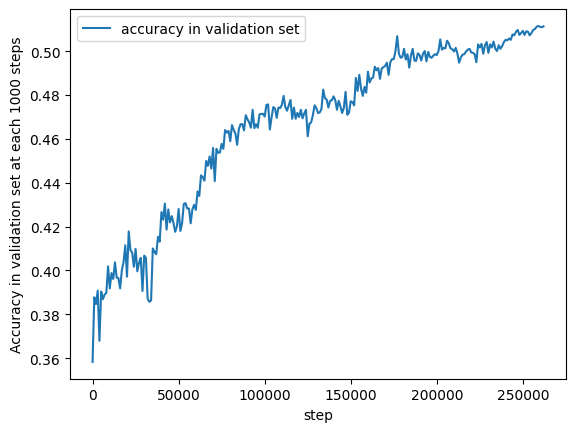

In [17]:
from matplotlib import pyplot as plt
steps = [1000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 1000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

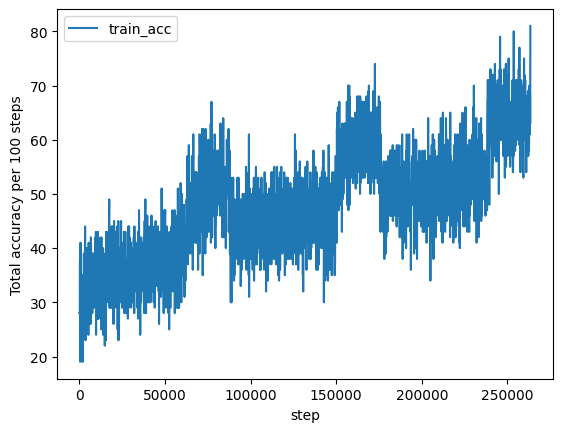

In [14]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

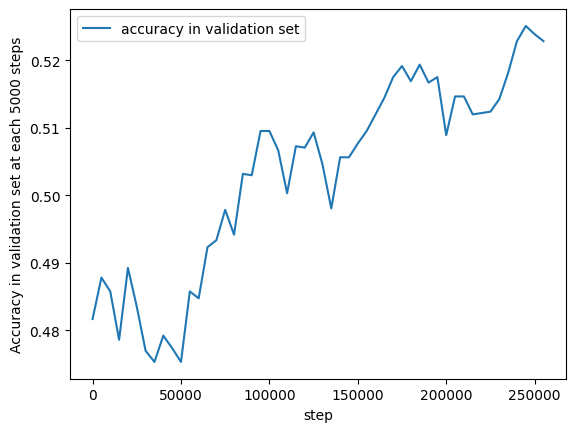

In [35]:
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

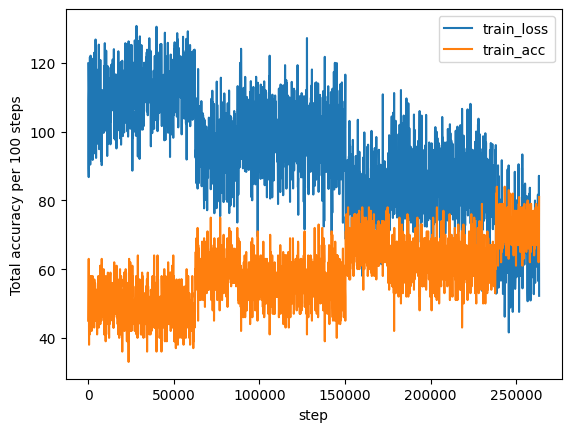

In [36]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

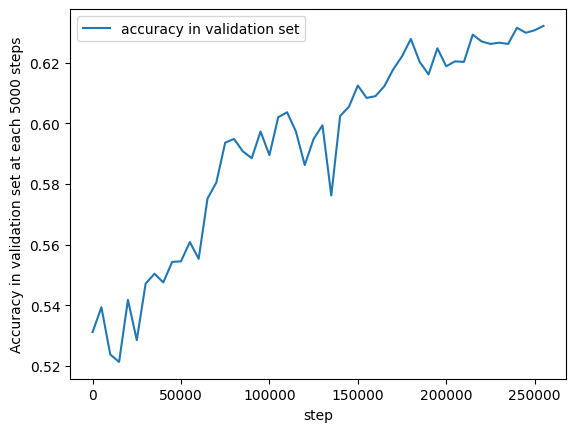

In [69]:
#Base Flan-T5
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

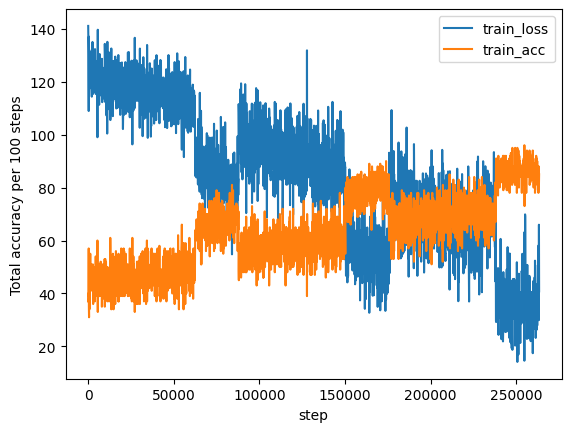

In [67]:
#Base Flan-T5
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

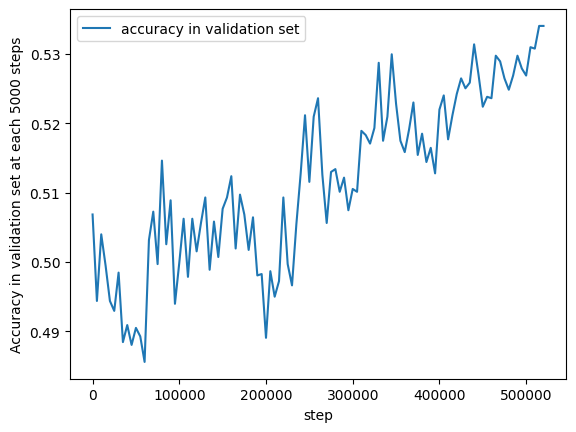

In [79]:
#Small Flan-T5
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

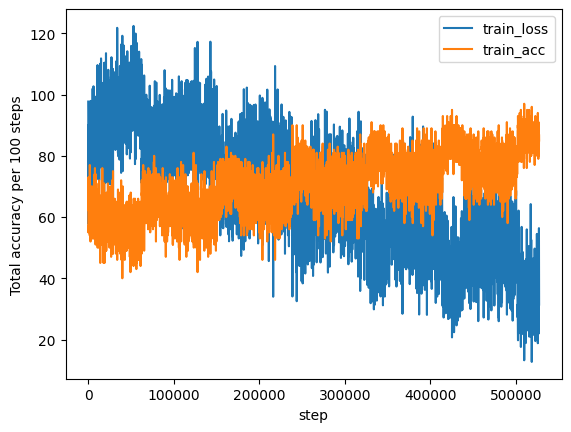

In [80]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [38]:
test_input_ids = tokenized_datasets["test"]["input_ids"]
test_labels = tokenized_datasets["test"]['answer']


In [28]:
large_model_test_accuracy = evaluate(model_large, test_input_ids, test_labels)

  0%|          | 0/4934 [00:00<?, ?it/s]

In [30]:
print(large_model_test_accuracy/len(test_input_ids))

0.7115930279691933


In [31]:
small_model_test_accuracy_based = evaluate(model, test_input_ids, test_labels)


  0%|          | 0/4934 [00:00<?, ?it/s]

In [32]:
print(small_model_test_accuracy_based/len(test_input_ids))


0.39319010944466964


In [36]:
for i in range(3):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.4641264693960276


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.49432509120389134


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5087150385083097


In [39]:
for i in range(3,6,1):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 4, accuracy is 0.4983785974868261


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 5, accuracy is 0.5127685447912445


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.5214835832995541


In [78]:
for i in range(0,12,1):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.4641264693960276


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.49432509120389134


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5087150385083097


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 4, accuracy is 0.4983785974868261


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 5, accuracy is 0.5127685447912445


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.5214835832995541


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 7, accuracy is 0.49918929874341306


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 8, accuracy is 0.5097284150790433


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 9, accuracy is 0.516214025131739


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 10, accuracy is 0.5214835832995541


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 11, accuracy is 0.5210782326712606


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 12, accuracy is 0.5249290636400487


In [40]:
model_base = "google/flan-t5-base"
tokenizer_base = AutoTokenizer.from_pretrained(model_base)
model_base = AutoModelForSeq2SeqLM.from_pretrained(model_base).to(device)

In [41]:
base_model_test_accuracy = evaluate(model_base, test_input_ids, test_labels)
print(base_model_test_accuracy/len(test_input_ids))


  0%|          | 0/4934 [00:00<?, ?it/s]

0.6035670855289825


In [184]:
model.eval()
input_ids = tokenized_datasets["test"]["input_ids"]
labels = tokenized_datasets["test"]['answerKey']
model_outputs = []
probability_output = []
for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_outputs.append(index_to_ans[np.argmax(preds_prob)])
        probability_output.append(preds_prob)
        
result = 0
for i in range(min(len(model_outputs), len(labels))):
    if model_outputs[i] == labels[i] or ans_to_index[model_outputs[i]] == labels[i]:
        result += 1
result
#946

1049

In [185]:
# torch.save(model.state_dict(), "model/flant5_small_lr_10-5_qa_finetuning")
# model.save_pretrained("model/flant5_small_lr_10-5_qa_finetuning")

In [129]:
model_distill = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [130]:
optimizer_distill = AdamW(model_distill.parameters(), lr=1e-4)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler_distill = get_scheduler(
    name="linear", optimizer=optimizer_distill, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
model_distill.train()
loss_array_distill = []
acc_array_distill = []
eval_results_distill = []

loss_per_100 = 0
acc_per_100 = 0
c = 0
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader):
        # print(batch)
        # labels = torch.tensor(, requires_grad=True).to("cuda")
        labels = batch["labels"].clone().detach().requires_grad_(True).to(device)
        # labels.retain_grad()
        labels = labels.squeeze()
        labels = torch.nn.functional.softmax(labels, dim=-1)
        # print(labels)
        # labels = batch['labels'][0].to(device)
        batch = batch['input_ids'].to(device)
        # print(batch)
        outputs = model_distill(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        # print(outputs)
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")

        preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]
        # print(preds)
        # print(labels)
        if torch.argmax(labels) == torch.argmax(preds):
            acc_per_100 += 1
            
        loss = loss_fct(preds, labels)
        # loss.retain_grad()
        loss_per_100 += loss.item()
        if c%100==99:
            print(loss_per_100)
            loss_array_distill.append(loss_per_100)
            acc_array_distill.append(acc_per_100)
            
            loss_per_100 = 0
            acc_per_100 = 0
        
        optimizer_distill.zero_grad()
        loss.backward()
            
        optimizer_distill.step()
        lr_scheduler_distill.step()
        # progress_bar.update(1)
        c += 1
        if c%5000==4999:
            eval_result = evaluate(model_distill, validation_input_ids, validation_labels)
            eval_results_distill.append(eval_result)
            # print(eval_result)
    model_distill.save_pretrained(f"model/flant5_small_lr_10-4_race_distill_epoch{epoch}")
    


  0%|          | 0/87866 [00:00<?, ?it/s]

142.2494912147522
137.68477314710617
138.2514117360115
138.56166273355484
140.22122812271118
141.90746599435806
135.55826205015182
139.7240738272667
140.17902660369873
137.66256266832352
137.59213465452194
133.78750878572464
135.98177728056908
138.1237980723381
136.31721058487892
135.87784492969513
135.0477465391159
129.1773834824562
139.59594810009003
137.94374787807465
135.1852204799652
126.8271074295044
138.62954926490784
137.56891244649887
138.8472000360489
135.72265714406967
133.47306191921234
139.8867478966713
137.30359995365143
133.30006402730942
138.96161568164825
134.61381512880325
136.65293329954147
133.49454367160797
136.38131254911423
139.1307190656662
136.47042548656464
132.73753494024277
134.5822727382183
137.4556286931038
137.47565668821335
135.15318846702576
135.9791784286499
135.0097994208336
131.55863907933235
135.41521680355072
133.8093220591545
133.5283768773079
128.937290340662


  0%|          | 0/4887 [00:00<?, ?it/s]

138.67970818281174
129.23445773124695
128.28146114945412
132.3005849123001
131.96850043535233
116.21117889881134
135.86333814263344
131.402100533247
134.6377598643303
129.52969998121262
129.3761466741562
130.94267949461937
123.6032672226429
136.16923561692238
132.80400931835175
127.28799200057983
134.33570683002472
127.13711547851562
125.94416388869286
131.62199276685715
127.9666556417942
127.44008302688599
133.21665713191032
126.57783913612366
129.57268887758255
130.0517654120922
131.47754818201065
132.26787734031677
128.53087604045868
121.111064478755
123.1434675604105
127.14508602023125
130.4995390623808
126.34020963311195
130.42630749940872
124.11519999802113
128.90927359461784
123.94834816455841
128.50133690238
130.6608588397503
123.57890821993351
125.92153352499008
128.93776178359985
128.5905104279518
131.71769186854362
123.98326805233955
129.9824174940586
124.3192160576582
132.68139991164207
130.1824845969677


  0%|          | 0/4887 [00:00<?, ?it/s]

131.3661721944809
128.9045622497797
127.76660150289536
130.35833007097244
124.96458320319653
128.4621658027172
130.58468908071518
129.7464093118906
127.04611018300056
122.16526241600513
130.09371453523636
132.68456971645355
120.9472744166851
126.83864033222198
128.27767911553383
125.35453861951828
125.8017807006836
125.00693672895432
130.2162863612175
124.24584838747978
127.51972967386246
127.8345900028944
125.68294161558151
125.98286163806915
122.84094688296318
124.98486867547035
127.48935870826244
126.85965767502785
120.31781986355782
118.97104812413454
117.37991261482239
124.13197329640388
133.64575698971748
125.18836358189583
124.29096138477325
128.78222411870956
128.87577733397484
124.84434121847153
125.56834918260574
119.53911256790161
120.70459149777889
125.21410551667213
130.40883848071098
125.39266879856586
128.58139789104462
119.23421096801758
126.70355622470379
129.47739323973656
120.41016671061516
130.647706925869


  0%|          | 0/4887 [00:00<?, ?it/s]

127.54899603128433
128.3392649590969
133.42797881364822
122.19647628068924
117.76192453503609
125.50933489203453
122.99423868954182
128.89732010662556
123.65206557512283
125.16129732131958
119.35402902215719
126.49421912431717
128.94025713205338
114.43650893867016
118.87809093296528
115.53809474408627
113.3882378488779
120.63937146961689
125.70931755006313
118.88316337764263
125.5765855461359
126.4919703900814
124.01733103394508
119.70739883184433
130.44356659054756
117.92832027375698
125.84892664849758
123.9631908684969
123.53517839312553
126.10346820950508
123.20068238675594
126.6860103905201
122.164664670825
124.34917232394218
122.66867271065712
118.63368119299412
127.41874569654465
117.12356877326965
119.17422018945217
117.3919241130352
127.89034867286682
115.60066471993923
119.50307983160019
123.90608222782612
123.8859438598156
124.8847866654396
127.00422324240208
124.50834256410599
124.8208096921444
120.96928560733795


  0%|          | 0/4887 [00:00<?, ?it/s]

124.17176721990108
119.33409199863672
126.32688683271408
119.08133418858051
116.16848894953728
126.45940965414047
122.84027209877968
122.93401108682156
118.9369486272335
122.32781273126602
119.28771063685417
111.24434743821621
123.05515369772911
122.97314397990704
124.66192203760147
121.77113933861256
123.07990948855877
124.04024546593428
130.27212193608284
118.35783645510674
114.83738221973181
124.73568388819695
115.07827021181583
124.1131450086832
119.92029727250338
123.00956486165524
124.6014698036015
124.586365878582
119.72837507724762
123.2628308236599
115.73888203501701
118.26115475594997
125.92645151913166
126.53724619746208
113.9921763241291
120.31613129377365
126.18608748912811
121.52903352677822
117.44016221165657
125.68791948258877
115.79498441517353
119.3645261079073
108.32327169179916
131.0159937441349
122.08471189439297
126.7268930375576
123.63795128464699
118.26267702877522
116.20247782766819
122.04580271989107


  0%|          | 0/4887 [00:00<?, ?it/s]

116.57822824269533
126.57569383084774
125.09346848726273
121.61208313703537
128.665643543005
119.37330318242311
121.51036346703768
118.80799168348312
124.12159478664398
110.55953513085842
115.49423614144325
118.04825957491994
116.57057769596577
122.56656940281391
123.42450687289238
115.78811806440353
120.17867934703827
126.24719722568989
123.740429520607
123.09802082180977
118.25293977558613
116.71819059550762
122.15623053908348
131.0836223065853
126.24040260910988
117.62328846007586
127.35813696682453
124.0044130384922
115.43786892294884
123.45421892404556
118.95610058307648
122.37398919463158
128.95024353265762
120.70199182629585
128.20679423213005
120.40551868081093
115.56695248186588
117.47459053993225
123.32672184705734
130.0492722839117
120.31216415762901
113.4014737457037
123.24449920654297
119.16840475797653
126.21584171056747
116.12983456254005
116.05918927490711
116.59477889537811
126.88810344040394
117.78546721115708


  0%|          | 0/4887 [00:00<?, ?it/s]

120.1101526170969
114.12900838255882
119.35941098630428
132.2096994444728
117.49180659651756
115.61573296040297
127.72381448745728
116.88620233535767
116.02526768296957
127.91134813427925
119.13294440507889
114.64011976867914
127.95964220166206
107.21654509007931
122.42521767318249
116.30525051057339
117.43573554605246
120.88578194379807
120.21021309494972
113.04445818439126
119.49729657173157
122.07794517278671
123.12692560255527
119.8698779642582
127.96174436807632
118.12843522429466
115.25833334028721
120.64830231666565
117.2862539589405
118.58738910406828
117.16753435134888
118.34087662398815
120.37443616241217
115.15189656615257
119.6500273346901
118.8021252155304
117.90531207621098
128.63114823400974
124.83160038292408
126.3440859913826
120.58331713080406
121.72144293040037
121.99922597408295
122.62166561186314
112.06317926943302
126.99251563847065
123.24048855900764
124.87400209903717
112.93553419411182
110.93373745679855


  0%|          | 0/4887 [00:00<?, ?it/s]

125.45897506177425
119.88648493587971
116.66045209765434
113.4843995347619
116.59854112565517
126.56100569665432
120.08867219090462
123.67167937755585
136.2096674144268
119.23534707725048
118.37380628287792
118.80715009570122
121.11825160682201
113.46674713492393
119.87506188452244
124.20969235897064
116.41574041545391
112.60871832072735
120.1597148515284
115.55387587100267
128.16772791743279
117.30010356009007
122.51198513060808
119.10991315543652
119.47613409161568
112.07289231941104
116.96489235013723
112.24506752938032
118.10132659971714
115.78300143778324
120.88241459429264
116.19402898102999
106.67624321207404
124.36960129439831
111.61771158874035
114.74585811048746
115.31381948292255
127.52241154015064
123.73651540279388
120.29678416252136
117.0283090621233
124.48978072404861
120.44777055084705
120.8076466023922
107.05502786301076
116.49360081553459
116.9762669801712
118.05080384016037
121.2713214457035
114.13440068811178


  0%|          | 0/4887 [00:00<?, ?it/s]

124.9887076318264
127.48415940254927
120.78816497325897
118.82344314455986
118.49603878706694
121.64512822031975
108.39923255890608
110.75061290338635
113.24765365570784
118.97444674372673
120.63175773620605
120.96623095870018
120.58042794466019
128.66760225594044
119.0419500246644
118.66300907731056
122.40669599175453
109.55733697861433
117.93053307384253
123.7815565392375
123.35032537579536
116.39410860836506
110.34334718436003
123.10929449647665
120.04203927516937
124.65258564800024
118.98915274441242
118.21795265376568
121.04270067811012
124.90374091267586
113.81811012327671
118.54961732029915
122.9365758895874
122.60180629789829
117.06727436184883
114.69481740519404
115.39812272787094
116.65410715341568
113.29966948181391
121.39764800667763
115.85339081287384
126.96298494935036
123.68846814334393
118.26742914319038
116.31831367313862
108.77100526541471
106.71414910256863
120.9445411041379
110.28758660703897
125.49497106671333


  0%|          | 0/4887 [00:00<?, ?it/s]

116.6188323572278
118.6671436727047
111.43123785406351
108.66287868469954
111.98354423046112
108.78972697257996
106.56252831965685
122.158138230443
121.87916155532002
118.75284320116043
119.55075354874134
117.83826590329409
104.55845932662487
112.09423422068357
125.22387211769819
127.50298796594143
122.90155424177647
119.76238352060318
115.06073937192559
118.99147138744593
121.02885085344315
122.59243033826351
111.06450827419758
125.08644458651543
123.30682104825974
123.45851668715477
123.99902403354645
126.14685812592506
121.46912506222725
108.50009403377771
115.84572514146566
112.54717200249434
113.94743812084198
127.94468948245049
121.06972020864487
118.93228878080845
113.34216599911451
116.0503349006176
120.09975036978722
100.4327338412404
119.06688050180674
111.74730068072677
119.5542295947671
123.14539575576782
121.26937073469162
113.66267235577106
119.71646448969841
110.56259979307652
110.58817080780864
117.7458997219801


  0%|          | 0/4887 [00:00<?, ?it/s]

111.83233742415905
111.03293454647064
122.54310756921768
119.25842541456223
118.78250439465046
113.15929786860943
119.96765921264887
122.43352348357439
118.73305441439152
114.567960947752
122.44134658575058
109.59650412201881
116.5348729044199
116.52913630008698
112.46473623812199
115.22871641814709
120.30461229383945
116.84951347857714
123.32089614868164
113.45464291423559
129.3162958920002
124.50294995307922
110.38338221609592
106.63967229425907
117.24920856207609
122.34047535061836
114.27730935811996
98.4315624833107
118.25258573144674
119.42295986413956
114.35925796627998
127.17356480658054
111.12630943953991
112.72817772626877
113.67737217247486
119.40772615373135
113.92594808340073
121.41797909140587
113.90382247418165
108.61835743486881
123.71073713898659
119.53942093253136
113.98854828625917
117.8615140914917
111.01558628678322
108.0966761559248
107.81373015791178
110.55826133862138
106.82318559288979
117.38917621225119


  0%|          | 0/4887 [00:00<?, ?it/s]

124.46980602294207
116.0112681761384
118.5476381778717
114.7284959256649
114.85982298105955
121.88651633262634
109.42565575242043
119.46484740078449
122.57482567429543
114.23176987469196
110.47841084375978
111.7933727428317
112.36667235940695
122.16175743937492
117.35297548770905
119.10099440813065
112.19385962933302
125.5274151340127
123.53477062284946
121.73961019515991
118.04230682551861
117.70136247575283
112.70004554837942
116.65304715931416
122.20199748128653
115.55624789185822
107.68227541260421
106.32936956733465
108.9155411273241
118.4285536184907
117.57663454115391
118.19633332267404
107.40906600654125
125.07883143424988
121.8153690546751
118.22105960547924
117.91847122460604
107.06242102384567
114.74005651473999
114.83983759582043
113.57895340584219
116.11301127821207
113.95778722316027
123.09884649515152
115.37902408838272
120.02641585469246
126.78101119399071
117.23218148946762
115.31546100229025
117.95097863674164


  0%|          | 0/4887 [00:00<?, ?it/s]

110.64396899193525
108.60242208093405
121.94045040011406
114.16577190160751
117.49134503304958
119.11504238843918
120.38706678897142
105.19408217817545
116.66932466253638
110.8990489244461
107.6294881850481
118.4704233109951
120.64329229295254
118.53277436643839
114.19503945112228
112.63940500095487
107.27178518846631
121.7814318202436
106.00473686307669
113.67221396788955
131.6348757147789
116.21605046093464
116.23187313973904
120.74979576468468
122.19751184433699
113.119543120265
108.42210192233324
108.29429293423891
114.6023301128298
105.99660731479526
104.91784050129354
96.90596903301775
90.97366819158196
99.18491510301828
106.92826296389103
105.2451936379075
98.68268132209778
102.19055393338203
107.80130901932716
87.6977587947622
88.61128836590797
100.33357679657638
84.06028605159372
105.03552291169763
91.57294031605124
107.67209567688406
99.051941646263
95.40083448961377
92.81946394592524
101.91845885850489


  0%|          | 0/4887 [00:00<?, ?it/s]

100.59349954873323
86.15921948850155
100.98657113034278
100.58649355359375
104.98331309109926
97.27298615500331
106.99909593164921
92.89011889696121
103.25104656815529
94.8533531986177
105.80403296649456
87.44478339701891
103.09793118201196
105.42223543487489
86.3339375257492
100.89022336900234
85.82621036469936
93.74703106377274
94.79886187240481
95.69649457931519
97.16205860301852
96.9927734611556
109.93051696382463
101.52815513126552
88.59702510014176
91.22999314963818
99.35430586710572
88.46504714619368
81.76429699035361
94.31388531625271
96.93330454081297
103.6049991697073
87.54260864853859
84.35463590919971
73.98192228935659
104.23340363614261
100.27507428638637
97.96961914747953
88.66620820946991
98.45833547413349
98.60173319745809
102.17793449759483
87.9383338727057
106.3143831025809
110.05943020060658
93.43867483735085
95.82189282588661
102.61590855196118
96.032958060503
98.9771100282669


  0%|          | 0/4887 [00:00<?, ?it/s]

90.1890753172338
86.2898657657206
87.48235482722521
95.24809488281608
99.7354646064341
92.08673468977213
105.59821574389935
96.49205977842212
91.69711864739656
94.59196517057717
90.83606475777924
99.00654359161854
94.33256869297475
92.25253669917583
98.73395127430558
80.71810305304825
98.68675429932773
86.50299764052033
82.94103739783168
91.27673061471432
97.48150298371911
98.440903859213
96.62516886368394
86.40616675466299
94.07777229137719
99.86497989669442
108.91031501442194
95.90591041743755
97.5951812081039
92.81558298505843
97.14853233471513
96.49020091071725
99.04627935215831
97.06456223875284
93.81158981472254
94.82674586214125
109.34033006615937
98.55085223540664
80.63680990226567
88.62602159008384
94.46125634014606
96.0659155882895
91.50185116752982
89.76766767911613
97.75360447354615
85.11223675403744
94.67736673727632
89.43903890252113
79.93160926550627
88.04766787961125


  0%|          | 0/4887 [00:00<?, ?it/s]

101.36222450435162
69.96914271265268
111.16121090296656
95.59885161370039
91.05905755702406
93.99679627642035
105.12422940135002
95.90186313167214
92.07289743889123
91.44764752686024
95.59270993992686
101.34849960636348
93.36543809995055
100.7415330838412
96.7794893104583
86.59123147651553
92.30802701413631
78.84986165165901
73.11588808335364
97.98745609633625
87.3857661113143
95.26051308959723
82.45341300778091
89.96552629116923
95.61710119619966
93.87162612751126
111.65174256265163
101.80940507352352
93.77652363851666
97.21652745269239
102.28470988478512
88.77086144499481
95.61334989219904
92.77448106557131
81.77161059901118
100.23642141371965
94.59992868080735
91.32377419248223
99.93837632145733
92.83570284768939
104.11030527576804
89.02616273611784
88.08756999671459
99.38700070977211
100.11219410225749
93.47344883158803
89.6237476952374
103.23791890963912
95.67956760525703
91.06361491978168


  0%|          | 0/4887 [00:00<?, ?it/s]

95.53022579848766
97.97172894142568
94.83821861818433
87.14517121389508
88.8516556918621
110.47307499498129
99.91053415834904
85.82945503108203
103.4779535792768
84.78586368262768
87.6647436991334
66.98611653037369
88.88522271625698
76.10273540206254
78.64302143454552
94.17483239248395
92.96985470503569
90.37056926265359
90.13138668239117
103.81586548686028
80.80906450003386
92.43146164342761
96.08243905380368
95.58356094919145
100.50770568102598
86.9079363271594
89.21655952557921
87.46565024089068
89.04678199067712
93.17969462834299
89.71761869639158
88.41113345697522
91.00273920968175
81.73299146536738
87.24521143734455
89.13585871830583
93.15582260675728
101.62336908467114
87.1406322773546
84.1782886851579
86.00683800317347
68.17200686968863
89.16165884397924
90.37785420566797
90.3121583238244
97.16405476629734
84.48044550791383
94.12933094240725
96.60310206376016
90.2853776589036


  0%|          | 0/4887 [00:00<?, ?it/s]

96.54516638815403
98.34399529919028
88.33051797002554
81.15835576504469
102.44894352555275
87.3637096658349
98.56692141480744
89.40896417293698
93.11492457613349
87.93653694912791
95.43728868477046
77.98241789638996
94.41865800693631
91.66973649710417
94.48369212541729
93.02258629724383
82.70512067526579
81.70744051784277
86.6630586143583
89.02061028033495
89.55049754213542
89.70077653415501
59.55699263326824
86.42586051113904
100.04313869215548
91.55858598649502
92.69844455458224
106.51534719951451
77.54993198346347


  0%|          | 0/87866 [00:00<?, ?it/s]

98.35612040571868
110.63517986238003
113.45508976280689
102.1818875297904
105.248739823699
113.54661467671394
117.98841962218285
105.027354195714
115.42944167554379
119.0823178961873
108.44843655079603
118.87173771858215
101.61804264038801
119.3281628638506
100.47022765129805
123.07540205866098
116.07562576979399
104.75478818267584
104.77174431085587
112.11679685674608
103.78842771053314


  0%|          | 0/4887 [00:00<?, ?it/s]

104.87242452055216
100.93695494905114
112.21741645410657
116.40896949917078
118.6574086099863
107.39693893305957
115.25131899118423
115.27156010270119
104.37016677111387
116.71020691655576
110.01193413883448
114.77815793454647
109.99591520428658
111.32310004904866
104.23467575386167
106.01495485380292
114.14185175299644
114.00928670167923
118.4781219959259
113.95060653239489
112.17525403946638
117.56760810315609
107.87934963032603
121.37563631683588
98.48868093639612
119.40028424561024
109.82333306968212
106.99224454164505
111.76171278953552
109.54763718880713
104.51564601063728
119.85818827152252
106.86451018974185
102.49250647053123
99.5545288156718
115.99851694889367
113.29390367865562
106.82096480578184
102.1092828065157
104.4247661754489
94.62412064149976
105.94600974954665
103.58374857529998
103.36884294822812
107.44215308502316
119.64546789973974
107.37063623219728
109.82411237433553
99.27176008373499
114.27670111320913


  0%|          | 0/4887 [00:00<?, ?it/s]

93.86432173103094
113.49711902812123
108.81169295683503
95.66771442815661
101.49914054945111
98.14090614765882
102.52297890931368
108.39620458334684
85.1625149846077
98.00727961212397
113.24214912950993
103.28065529838204
99.0480310767889
106.38630221039057
107.96265624463558
107.50759240239859
111.69671107083559
96.2201858498156
95.18767651543021
97.85615226253867
101.35115098580718
106.97114155814052
92.8308314345777
107.65760733559728
98.3050664961338
109.69985467754304
110.09261975809932
113.68303316831589
105.13108926266432
112.18390971422195
101.05828224867582
105.1318872012198
109.97552644833922
102.82662454247475
103.43949430808425
105.04852847009897
98.95863031875342
110.57725834101439
98.93073587864637
108.79826397448778
106.78827103972435
81.03987996838987
115.35662047564983
107.43801172450185
98.05395443737507
92.72187692672014
116.2662899363786
110.02650581672788
106.26998859271407
101.21710453927517


  0%|          | 0/4887 [00:00<?, ?it/s]

100.89304035902023
98.69512293487787
105.46754179149866
99.66600668802857
97.0233562272042
95.64123990572989
111.81353272497654
90.18983679264784
89.44438844546676
103.58878503739834
96.05585043132305
99.06695730611682
109.80546678975224
106.51184545084834
106.86285652965307
105.15307320281863
105.32506553083658
102.97509964928031
98.56789914146066
99.62183533608913
94.16677203401923
104.16385762766004
100.93290303647518
110.12542425096035
93.0848433393985
116.9360388815403
102.75387433171272
105.62156044878066
107.61121273040771
113.7317821867764
105.11934707313776
112.88115152344108
84.41691556759179
100.50927318818867
104.52040423825383
97.44553277269006
104.9784172475338
97.02383622527122
99.89457671716809
103.18412950634956
108.44966111704707
100.25092474371195
89.82781192660332
96.88613149616867
93.86552233621478
78.41569582559168
91.51851173117757
97.48792947083712
102.19936500862241
101.59932911768556


  0%|          | 0/4887 [00:00<?, ?it/s]

100.50030386075377
100.40656975284219
86.54623042419553
116.0951506793499
93.9521529302001
103.46075662225485
98.8404447697103
97.65972580760717
118.99848534166813
100.36629535630345
96.99030740186572
105.96166940778494
93.88232109695673
89.9123072270304
102.30312053114176
102.00556561350822
91.04202608205378
85.4647068362683
93.11666698008776
102.60015412420034
97.49960077926517
94.52118704095483
105.98680686205626
104.82790440320969
106.12558967620134
109.66527131199837
100.67991701327264
104.6812570951879
101.34172100201249
104.69842486083508
93.25306247547269
103.4364716745913
104.58745491318405
91.46325880289078
98.81113476678729
91.43004044145346
106.28259798139334
103.41697684302926
95.95880319923162
93.2286915089935
83.67121384479105
104.4350565019995
105.34422293677926
97.40540024638176
104.78821804374456
92.2008993960917
114.77914950996637
105.32028172910213
89.06702441722155
84.22423871792853


  0%|          | 0/4887 [00:00<?, ?it/s]

98.97872587293386
85.16993922367692
108.81451471708715
101.68256741482764
99.20325015485287
94.84153646696359
107.16072653979063
95.1647308729589
91.79878093022853
93.50001730769873
87.53032874315977
106.36091599613428
101.92035859823227
93.34721487015486
94.95259530097246
98.90142791718245
98.85555562376976
105.76753887534142
103.26522499322891
100.0848370231688
96.56093559414148
74.9857679978013
111.52783204615116
89.87645494192839
99.95702366903424
106.12494775652885
94.77416789717972
83.14955240860581
99.46138555184007
90.0501717813313
106.39453451149166
95.29926947876811
109.43855911679566
102.76174149662256
92.50748719461262
103.21635296940804
95.9604612160474
82.52318011969328
92.43125900812447
92.73105481639504
88.75878733769059
86.71693751588464
99.05912518501282
96.1159408017993
85.69775692000985
96.8059816872701
101.82499927282333
103.243133418262
109.71701915562153
85.20493452996016


  0%|          | 0/4887 [00:00<?, ?it/s]

95.97495612129569
93.28222955018282
114.69092854484916
98.39405938237906
107.72341471165419
102.2653760612011
98.09896384552121
93.42623880133033
106.82154583185911
93.75660967826843
98.96889078617096
99.826007489115
98.04152220487595
102.17941578477621
104.83910941332579
80.0465190038085
102.26731475442648
99.08589319698513
109.99846763163805
99.1416874974966
89.95775002986193
109.15932594612241
94.00474785268307
107.46895691379905
88.97984164953232
89.09075301140547
91.16241445951164
103.20115704461932
97.67500994727015
94.99250116199255
81.45971618592739
96.86205284297466
110.80069841071963
94.87453224509954
90.72086424008012
93.96766099333763
95.58449912816286
94.47008419595659
95.46034640818834
86.84028726816177
98.4138502907008
106.18584207817912
81.45811052620411
99.6658032014966
88.2334876768291
100.38464243058115
110.05530845746398
85.44860269129276
83.89843701943755
109.55660805851221


  0%|          | 0/4887 [00:00<?, ?it/s]

94.89555076509714
103.52737564593554
94.40651544369757
102.07525977864861
86.74804522097111
89.01315745711327
98.81043345853686
96.1972037255764
85.16048954240978
88.09466008841991
88.47027334570885
99.01591453142464
89.46603399887681
101.10649634152651
101.27111470326781
104.39544923231006
103.72697317972779
95.91984331794083
101.53009621053934
94.95885749720037
92.37030308321118
94.94716738536954
96.72140742093325
95.42498004809022
110.42089720442891
102.9041001740843
99.56491253525019
92.76578998193145
89.76350260525942
96.74426673166454
103.57335902750492
89.39225470274687
98.71362931467593
75.07433211058378
106.80677687376738
94.38860606402159
107.4073860310018
113.74681812524796
97.82986073382199
93.88000441342592
95.37335641309619
93.38841884210706
99.35337313637137
92.37427272647619
97.00918475538492
83.87406015023589
81.72775857150555
87.7575319595635
110.83479130640626
101.80556017532945


  0%|          | 0/4887 [00:00<?, ?it/s]

96.67213293910027
92.31186657771468
99.57879424048588
98.17511385679245
86.2274885699153
94.50388776510954
88.210304800421
90.357242166996
94.42950461246073
98.96489235013723
84.66533407568932
91.06615449488163
98.29752887785435
92.85941807553172
84.77786327525973
91.27494067698717
112.7455894201994
98.81286316365004
95.33861326426268
94.78042887151241
106.24229960516095
93.9470024742186
82.54246439784765
74.78249634429812
92.55192614439875
98.11909515038133
91.0538515560329
103.69228020496666
85.03187200427055
113.50270992424339
95.57951954379678
98.23860043287277
84.11854449659586
91.66161638312042
87.1685720058158
86.400121640414
81.21776534616947
97.06027119606733
96.00425127334893
95.24636161513627
87.36384123936296
102.31643039360642
104.15129660069942
101.9017136618495
96.94036692753434
95.13346912711859
93.49144717492163
91.15015281736851
96.11944712884724
96.40229696035385


  0%|          | 0/4887 [00:00<?, ?it/s]

78.34146538376808
99.97934489697218
98.71071408316493
107.13985149562359
96.13048186711967
82.58908600360155
99.08451204374433
86.94288246333599
102.82266809791327
90.19930475577712
91.09261579811573
95.04666175320745
102.295483879745
102.00442410912365
90.73893686383963
90.60008583590388
80.76415550522506
101.13223244436085
97.6311433762312
88.28355890139937
98.17757625132799
109.25152804516256
91.86167093738914
87.56255736015737
76.6781324967742
99.56353510916233
86.40779624506831
88.00385199300945
97.34759138524532
92.16350995004177
91.04242050088942
90.53178873285651
84.74816115759313
92.67347571626306
72.1062208712101
88.104318279773
102.81204615905881
93.43626902624965
94.48169353231788
91.06992829591036
88.68081432953477
92.45268945395947
82.24370472878218
99.52357707545161
109.63765078410506
91.63565352000296
93.42373323813081
89.58015260286629
86.86721668578684
106.58664735034108


  0%|          | 0/4887 [00:00<?, ?it/s]

90.97975733876228
85.28900046646595
91.04083164781332
106.9389406517148
108.22315772809088
102.6968033593148
96.09595066681504
87.7465284820646
90.11792845092714
84.41143815219402
76.84590982180089
89.02599786967039
104.26860539056361
97.1366172619164
87.56810207478702
87.13785045221448
91.68419216945767
97.12037229910493
86.8406121917069
82.92793080210686
95.15197889879346
95.75009275600314
96.90718026459217
91.05393438972533
95.00379881635308
90.5300905816257
93.89813402667642
88.46029917337
79.75267528556287
82.82084721978754
80.3499052952975
99.81910777837038
101.00213593244553
99.43794433400035
88.43396666646004
98.83666895702481
86.70545805059373
87.94701638072729
86.12206917861477
98.88220272958279
88.69132649712265
88.87642819434404
94.23952198773623
85.69495233893394
102.49374283850193
86.70367870852351
94.37007269263268
96.11070172861218
88.36806876584888
109.72327566891909


  0%|          | 0/4887 [00:00<?, ?it/s]

97.15524848178029
89.64573999494314
83.54395425319672
103.55680419132113
96.43416596204042
84.61395695060492
82.3862492851913
82.20070914924145
96.28101323544979
94.9234464969486
101.80292705819011
89.39621668681502
76.14861780405045
96.39251869358122
95.88832518830895
89.37646556645632
93.25065142847598
83.17505925893784
85.64894043654203
98.77149311825633
99.91879354044795
89.07858326472342
89.86256483569741
81.09565013833344
87.8221549615264
85.26205068640411
71.84001431241632
72.92879864573479
95.50164671987295
109.83039697259665
85.29955771565437
96.68413344398141
83.25560220144689
93.15676050679758
87.91355170216411
70.89153021760285
93.36199113726616
97.46539106220007
80.06943364068866
92.61823621019721
71.65054856613278
84.1972841732204
101.90637313388288
96.35892924293876
86.82500665076077
93.84460887685418
104.48087603226304
100.49239372462034
88.15771698579192
89.84747620671988


  0%|          | 0/4887 [00:00<?, ?it/s]

109.3277679849416
86.94537563621998
87.23677043430507
93.73091753199697
74.59147005248815
85.30800978001207
83.55515181645751
79.98949525877833
99.40271362103522
89.20488963089883
93.50909186527133
87.60297336243093
103.10904821194708
86.61486585438251
90.55238197557628
90.38521158322692
83.3797685392201
92.42473987862468
82.76377437263727
81.9753005579114
93.79340959712863
74.64600631780922
93.00260771997273
94.88418535143137
85.2066244399175
106.8420534543693
99.8729710765183
94.7309975028038
93.08768354728818
84.53271675948054
85.81567526608706
101.5560877174139
86.32101446390152
94.50112236663699
96.44863291084766
87.4777636770159
76.6253493539989
96.83519962057471
86.98199788480997
73.70994253642857
105.24005199503154
101.37204607948661
82.97236026450992
89.41945737414062
94.64083790592849
80.36609235033393
78.73721627704799
91.93496445193887
87.13761142455041
100.04990394413471


  0%|          | 0/4887 [00:00<?, ?it/s]

100.9475581087172
90.8747179992497
90.01225909590721
104.81513529457152
68.93537151440978
65.88333075400442
66.74859415180981
73.8948178710416
76.79696698859334
71.09621126949787
62.04667015746236
60.69317787885666
63.67414724826813
82.6424526181072
76.30308440886438
61.34140487574041
76.96039658412337
77.4686021450907
62.51672779582441
41.646104434970766
74.72152466326952
60.43216349836439
71.30146612785757
69.30988998385146
84.70563109964132
71.92308400012553
71.39525065384805
68.47559448704123
65.45938459178433
66.92101570777595
63.747552120126784
67.51594882830977
65.46650363877416
61.85652361996472
73.9865211949218
63.3810978946276
63.97386918310076
75.72362473700196
75.48297137953341
66.63224887289107
58.61060137860477
65.28241661190987
80.86721719801426
62.12744928151369
60.17361705005169
56.35761499963701
65.82007293077186
75.58141962438822
69.52997785527259
58.21145629603416


  0%|          | 0/4887 [00:00<?, ?it/s]

90.1037366501987
85.28466622531414
69.43371419236064
62.072450056672096
67.06025115121156
66.14215107634664
52.649593477952294
60.95628379331902
60.619477067142725
67.42286277934909
56.97488318569958
62.727622954174876
68.86693030409515
53.4823364270851
72.27044846303761
68.21908718720078
67.42478617560118
76.12520778365433
60.0050529721193
66.0835200920701
76.26223280653358
64.66433808393776
92.20344781689346
83.62302977405488
73.48465267196298
65.00783103890717
78.04621307738125
65.44101501628757
81.76717068627477
52.40409141778946
72.60254201292992
66.62479689437896
71.65666251862422
73.22958159632981
64.53662933781743
79.78571196645498
67.7812493480742
58.02114116959274
59.52751815225929
56.1035914439708
74.89988727075979
71.48647425323725
76.11175963655114
56.11148565635085
61.37443456239998
60.03666501119733
60.78991879988462
61.54696567263454
66.92089462652802
59.26308921352029


  0%|          | 0/4887 [00:00<?, ?it/s]

59.765922451391816
70.79980542883277
58.55875288695097
83.55742253828794
69.572873971425
65.70165331289172
69.99331363290548
64.9495482398197
73.0746594639495
73.55351359024644
67.64735523238778
69.89370049815625
76.91001594625413
57.698064926080406
82.06511403713375
81.99476897297427
61.533093336969614
41.74701527599245
55.40778653137386
61.293705785647035
65.93981832638383
69.53127252776176
52.56676419824362
66.80236609466374
56.98446194641292
67.44717860314995
65.92083767079748
61.361979003064334
64.18443839997053
65.30415951833129
59.117083095014095
76.04964988026768
66.80811463296413
63.16443758364767
67.96631163917482
58.62076111882925
75.3135846182704
62.02072063833475
62.8022801829502
60.90464558452368
78.08122942876071
54.51722088269889
71.06751727405936
63.10109255183488
61.800949265714735
56.15881701372564
63.68454357609153
56.87576309591532
60.873195454478264
65.63519541081041


  0%|          | 0/4887 [00:00<?, ?it/s]

57.82796492148191
73.29612082522362
60.65537849906832
66.27922608330846
82.52464800793678
82.12851995229721
77.21006668359041
61.99994494859129
65.05697879381478
66.63126309681684
57.79044606536627
69.27540738880634
60.69181988015771
56.94226650800556
60.7242541089654
71.07983775623143
57.77615287527442
76.86590351164341
63.36597623117268
83.45673659071326
48.46779683418572
64.51690538786352
74.28089326433837
64.51091349031776
63.62808290030807
68.13289074413478
61.79516282025725
71.32321846857667
64.08161899168044
72.30882536619902
76.19191005080938
63.62899243272841
61.533019471913576
60.969636872410774
81.1209776904434
66.50951096788049
51.30661845766008
70.21549146948382
63.62175811827183
51.267193106003106
51.09951760806143
65.12461540289223
40.07773194927722
76.54415773274377
53.848225438036025
64.5933356359601
52.79081360343844
70.47551104798913
56.10780439991504
68.5823259986937


  0%|          | 0/4887 [00:00<?, ?it/s]

66.63498356379569
72.67226624907926
66.00118912383914
73.60333750676364
62.724185924977064
51.407427000813186
54.16630877368152
58.12391004245728
61.1302649974823
65.35823674220592
60.963149486109614
58.44124754238874
60.73365741223097
60.62591752037406
45.422164395451546
69.77599313110113
62.905800136737525
65.1831403747201
55.3432495277375
51.6264659864828
42.110250058583915
50.57850981131196
67.46086271107197
67.04912206530571
61.31281877681613
59.36724653746933
73.78757610172033
66.25479132588953
61.57292036898434
55.3813853058964
79.99483463354409
60.54356514196843
74.4470535106957
61.66915948688984
54.750531220808625
73.45716239511967
59.8333325041458
51.78504678606987
58.59781463351101
64.09580079652369
60.16838647425175
53.23841778934002
59.80858907010406
58.67296588793397
57.53988452721387
53.88104985002428
44.65035909228027
61.43021420575678
73.3307403838262
56.0235668187961


  0%|          | 0/4887 [00:00<?, ?it/s]

56.66936075780541
47.58785986248404
58.3024264248088
67.75499016232789
67.13145740889013
65.52142985351384
66.04338000202551
60.979343857616186


  0%|          | 0/87866 [00:00<?, ?it/s]

86.88947387225926
100.00600003823638
94.65645230188966
68.31327398866415
87.49724366888404
98.4526203610003
89.2061361707747
84.2367689460516
86.44873813726008
88.71345605701208
93.56327348016202
91.45531900972128
85.16754296049476
82.55022372305393
87.44106488861144
93.43523482233286
94.24768545571715
75.63450573943555
87.25643008947372
92.14289369806647
80.57831608876586
84.44309919700027
84.1236050222069
80.46336360648274
101.94030531868339
89.62101444602013
87.76717620249838
94.99855137243867
105.42287519201636
75.92667469382286
98.19249229505658
79.55786795914173
94.15982998907566
69.84525481238961
73.78735607489944
89.65098715387285
92.21606820821762
87.8629200225696
94.3069613315165


<function matplotlib.pyplot.show(close=None, block=None)>

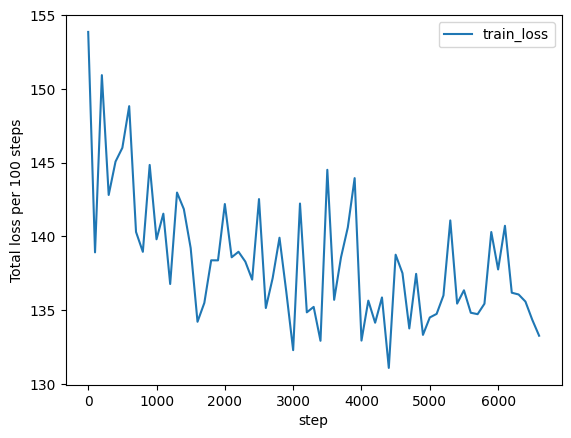

In [189]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(loss_array_distill))]
plt.plot(steps, loss_array_distill, label='train_loss')
plt.xlabel("step")
plt.ylabel("Total loss per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [190]:
model_distill.eval()
model_distill_outputs = []
labels = tokenized_datasets["test"]['answerKey']

for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model_distill(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_distill_outputs.append(index_to_ans[np.argmax(preds_prob)])
        
result_distill = 0
for i in range(min(len(model_distill_outputs), len(labels))):
    if model_distill_outputs[i] == labels[i] or ans_to_index[model_distill_outputs[i]] == labels[i]:
        result_distill += 1
result_distill

956

In [192]:
# torch.save(model.state_dict(), "model/flant5_small_lr_10-5_qa_distill_match_large_output_abcd")
# model_distill.save_pretrained("model/flant5_small_lr_10-5_qa_distill_match_large_output_abcd")


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)


In [ ]:
model_1_best = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model_1_best.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        highest_prob_index = np.argmax(batch['labels'][0])
        labels = [0.0] * len(batch['labels'][0])
        labels[highest_prob_index] = 1.0
        labels = torch.tensor(labels).to(device)
        batch = batch['input_ids'].to(device)
        outputs = model_1_best(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")
        preds_prod = []
        for i in range(1):
            pred_prob = []
            for t in ans_id_dict.keys():
                pred_prob.append(logits[..., t][0][0].item())
            preds_prod.append(pred_prob)
        preds = torch.tensor(preds_prod[0]).to("cuda")
        loss = loss_fct(preds, labels)
        loss.requires_grad_()
        
        # loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


In [ ]:
model_1_best.eval()
input_ids = tokenized_datasets["test"]["input_ids"]
labels = tokenized_datasets["test"]['answerKey']
model_1_best_outputs = []
probability_1_best_output = []
for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model_1_best(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_1_best_outputs.append(index_to_ans[np.argmax(preds_prob)])
        probability_1_best_output.append(preds_prob)
        
result = 0
for i in range(min(len(model_1_best_outputs), len(labels))):
    if model_1_best_outputs[i] == labels[i] or ans_to_index[model_1_best_outputs[i]] == labels[i]:
        result += 1
result

In [ ]:
probability_1_best_output